<a href="https://colab.research.google.com/github/davidArSo/Graph-Neural-Networks-para-la-deteccion-gradacion-y-prognosis-de-cancer-de-prostata/blob/master/GNN_SICAPv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

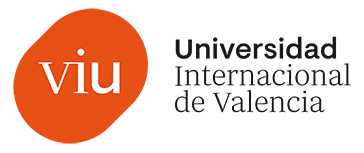

# **Graph Neural Networks para la detección, gradación y prognosis de cáncer a partir de imagen histopatológica**

#### *David Armenteros Soto*

<a name="indice"></a>
## **Índice**

0. [Preliminares](#Preliminares)
1. [Introducción](#Introducción)
    1. [Descripción del problema](#DescripciónProblema)
    2. [Descripción de la base de datos](#DescripciónDatos)
2. [Exploración de la base de datos SICAPv2](#Exploración_sicap)
    1. [Parches y máscaras](#parches_máscaras)
    2. [Tabla de clasificación según grados de Gleason](#tabla)
3. [Reconstrucción de Whole Slide Images (WSIs)](#reconstrucción)
    1. [Normalización de Whole Slide images (WSIs)](#normalización)
4. [Generación de nuevos parches sin superposición](#nuevos_parches)
5. [Representación de nodos y extracción de características de parches](#latente)
6. [Construcción de grafos mediante PyTorch Geometric](#construcción_grafos)
7. [Generación del conjunto de datos de grafos](#Generación)
8. [Graph augmentation](#augmentation)
9. [Construcción, entrenamiento y evaluación del modelo GNN](#Modelo)

<a name="Preliminares"></a>
## **Preliminares**
([Índice](#indice))

Montamos Google Drive en Colab

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Establecemos el directorio raíz donde se encuentran los archivos y datos del proyecto

In [ ]:
BASE_FOLDER='/content/gdrive/MyDrive/VIU - Máster IA/Asignaturas/TFM/GNN - Prostate Cancer'

Agregamos el directorio a la lista de rutas donde Python buscará al intentar importar librerías

In [ ]:
import sys

In [ ]:
sys.path.append(BASE_FOLDER)

Ahora sí, el entorno está preparado para importar las librerías que se encuentran en este directorio

In [ ]:
# Librerías
import os

# Utilidades de fichero (file_utils.py)
from file_utils import download_file, file_exists, unzip_file, folder_exists

Descargamos la base de datos SICAPv2

In [ ]:
# Uso de la función de descarga
url = 'https://data.mendeley.com/public-files/datasets/9xxm58dvs3/files/993cc418-2575-47e7-bb4c-de5200665717/file_downloaded'
destination_path = BASE_FOLDER
filename = 'SICAPv2.zip'

# Comprobamos si el fichero ya existe, para proceder o no con la descarga
full_path = os.path.join(destination_path, filename)
if file_exists(full_path):
  print(f'El fichero {filename} ya existe en {destination_path}')
else:
  download_successful = download_file(url, destination_path, filename)

El fichero SICAPv2.zip ya existe en /content/gdrive/MyDrive/VIU - Máster IA/Asignaturas/TFM/GNN - Prostate Cancer


Descomprimimos el fichero .zip

In [ ]:
# Uso de la función para descomprimir
zip_path = os.path.join(BASE_FOLDER, 'SICAPv2.zip')
destination_path = BASE_FOLDER

# Comprobamos si la carpeta ya ha sido descomprimida
unzip_folder_path = os.path.splitext(zip_path)[0]
if folder_exists(unzip_folder_path):
    print(f'La carpeta {unzip_folder_path} ya existe')
else:
    unzip_successful = unzip_file(zip_path, destination_path)

La carpeta /content/gdrive/MyDrive/VIU - Máster IA/Asignaturas/TFM/GNN - Prostate Cancer/SICAPv2 ya existe


<a name="Introducción"></a>
## **Introducción**
([Índice](#indice))

<a name="DescripciónProblema"></a>
### **Descripción del problema**

El cáncer de próstata es una enfermedad cancerígena que se origina en la próstata, una pequeña glándula con forma de nuez que produce el fluido seminal que nutre y transporta el esperma.

Una vez que una biopsia confirma la presencia de cáncer, el siguiente paso es determinar el nivel de agresividad (grado) de las células cancerosas. Un patólogo de laboratorio examina una muestra para determinar cuánto difieren las células cancerosas de las células sanas. Un grado más alto indica un cáncer más agresivo.

La escala más común utilizada para evaluar el grado de las células del cáncer de próstata se llama puntuación de Gleason. La puntuación de Gleason combina dos números y puede variar desde 2 (cáncer poco agresivo) hasta 10 (cáncer muy agresivo), aunque la parte más baja del rango no se usa con tanta frecuencia.

De acuerdo con las directrices actuales de la Sociedad Internacional de Patología Urológica (ISUP), las puntuaciones de Gleason se describen en un grado ISUP en una escala del 1 al 5:

| Gleason             | ISUP |
|---------------------|------|
| 2-6                 | 1    |
| 7 (3+4)             | 2    |
| 7 (4+3)             | 3    |
| 8 (4+4, 3+5, 5+3)   | 4    |
| 9-10 (4+5, 5+4, 5+5)| 5    |

Si no hay cáncer en la muestra, el grado ISUP es 0.

<a name="DescripciónDatos"></a>
### **Descripción de la base de datos**

La base de datos **SICAPv2**  contiene información relacionada con imágenes histológicas de la próstata. A continuación, se describe la estructura y contenido de los directorios y tablas dentro de la base de datos:

**Directorios**:

*   *images*: Contiene parches de histologías de próstata extraídos de una ampliación de 10x. Los parches tienen un tamaño de 512 píxeles y se superponen en un 50% entre ellos. Solo se seleccionan los parches que contienen más del 20% de tejido. El nombre de cada archivo sigue el siguiente formato:

  **Slide_ID** _ Block_Region _ **region_y_x** _ xini _ **xini** _ yini _ **yini**

  Cada nombre incluye un prefijo que indica el ID de la diapositiva, la posición de la región del parche mediante region_y_x y las posiciones xini y yini.

*   *masks*: Contiene máscaras con anotaciones codificadas de las imágenes del directorio "images". Las anotaciones en las máscaras se codifican con los siguientes valores:

  * 0: No canceroso

  * 1: GG3 (Gleason Grade 3)

  * 2: GG4 (Gleason Grade 4)

  * 3: GG5 (Gleason Grade 5)

*   *partition*: Contiene tablas que describen la partición propuesta de validación cruzada basada en pacientes de la base de datos, las etiquetas de los grados Gleason y la verdad del patrón cribiforme.

**Tablas**:

*   *wsi_labels*: Contiene información sobre las imágenes de histología de próstata. Incluye los siguientes campos:

  * wsi ID: Identificador de la imagen.
  * patient ID: Identificador del paciente asociado.
  * Gleason score: Puntuación Gleason, que incluye los grados primarios y secundarios del cáncer de próstata.

Se puede consultar y descargar SICAPv2 siguiendo el enlace: [SICAPv2: Prostate Whole Slide Images with Gleason Grades Annotations](https://data.mendeley.com/datasets/9xxm58dvs3/)

<a name="Exploración_sicap"></a>
## **Exploración de la base de datos SICAPv2**
([Índice](#indice))

En esta sección, comenzaremos definiendo las rutas de los archivos y directorios necesarios. A continuación, se implementará la clase *SlideDataset* que encapsula la lógica para cargar y transformar las imágenes del proyecto. Esta clase permite la creación de un conjunto de datos a partir de imágenes de parches de manera eficiente.

In [ ]:
# Librerías
import torchvision.transforms as transforms
import random
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clase SlideDataset (slide_dataset.py)
from slide_dataset import SlideDataset

Ruta base de SICAPv2 y estructura del directorio principal

In [ ]:
sicapv2_path = os.path.join(BASE_FOLDER, 'SICAPv2')

!ls "{sicapv2_path}"

images	masks  partition  readme.txt  wsi_labels.xlsx


Ruta de los distintos directorios y tablas

In [ ]:
# Ruta de los directorios
images_path = os.path.join(sicapv2_path, 'images')
masks_path = os.path.join(sicapv2_path, 'masks')
partition_path = os.path.join(sicapv2_path, 'partition')

# Ruta de la tabla
wsi_labels_path = os.path.join(sicapv2_path, 'wsi_labels.xlsx')

<a name="parches_máscaras"></a>
### **Parches y máscaras**
([Índice](#indice))

Uso de la clase SlideDataset para la generación del conjunto de datos

In [ ]:
# Transformaciones para parches
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),                                               # Nos aseguramos de que todas las imágenes tengan la misma dimensión
    transforms.ToTensor()                                                        # Normalizamos y transformamos a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Estandarización (solo para redes preentrenadas con ImageNet)
])

images_dataset = SlideDataset(images_path, transform_image)

In [ ]:
# Transformaciones
transform_mask = transforms.Compose([
    #transforms.Lambda(lambda x: x.convert('RGB')),                              # Transformación a RGB
    transforms.Resize((256, 256)),                                               # Nos aseguramos de que todas las imágenes tengan la misma dimensión
    transforms.ToTensor()                                                        # Normalizamos y transformamos a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Estandarización (solo para redes preentrenadas con ImageNet)
])

masks_dataset = SlideDataset(masks_path, transform_mask)

In [ ]:
# Número de imágenes en el conjunto
print(f'El conjunto de datos tiene {len(images_dataset)} parches')

El conjunto de datos tiene 18783 parches


Visualización de parches de imagen histológica y máscaras

Fichero:  16B0008045_Block_Region_0_3_5_xini_11089_yini_3611.jpg
Tamaño:  (512, 512)
Formato:  JPEG


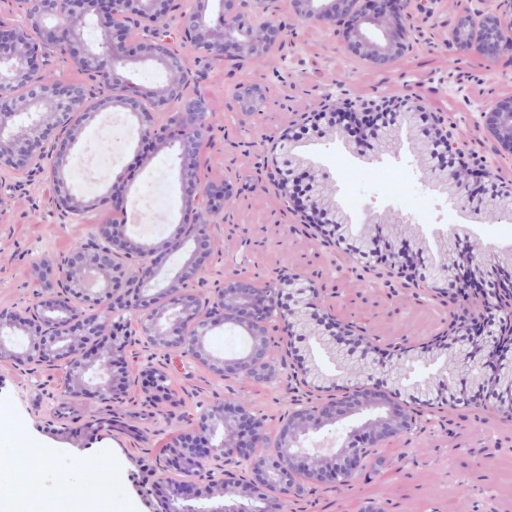

In [ ]:
# Podemos seleccionar y mostrar una imagen aleatoria ...
random_index = random.randint(0, len(images_dataset) - 1)
random_image_filename = images_dataset[random_index]["name"]
random_image = images_dataset.get_image_by_filename(random_image_filename)

"""
print("Fichero: ", random_image_filename)
print("Tamaño: ", random_image.size)
print("Formato: ", random_image.format)

display(random_image)
"""

# Sin embargo, mostraremos la imagen de ejemplo de la memoria
example_img_filename = '16B0008045_Block_Region_0_3_5_xini_11089_yini_3611.jpg'
example_img = images_dataset.get_image_by_filename(example_img_filename)

print("Fichero: ", example_img_filename)
print("Tamaño: ", example_img.size)
print("Formato: ", example_img.format)

display(example_img)

Fichero:  16B0008045_Block_Region_0_3_5_xini_11089_yini_3611.jpg
Tamaño:  (512, 512)
Formato:  JPEG


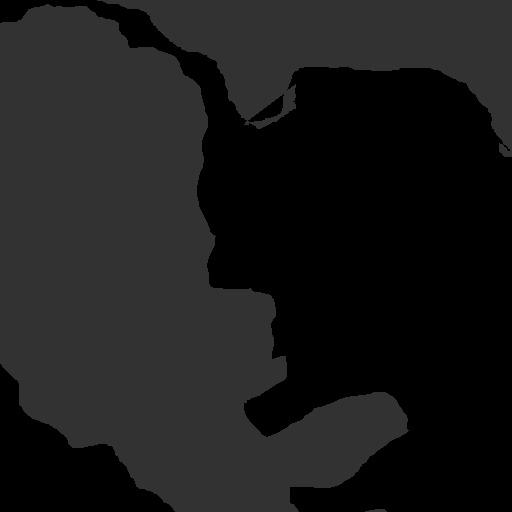

In [ ]:
# Mostramos la máscara asociada al parche de ejemplo
example_mask = masks_dataset.get_image_by_filename(example_img_filename)

print("Fichero: ", example_img_filename)
print("Tamaño: ", example_mask.size)
print("Formato: ", example_mask.format)

display(example_mask)

Los elementos de la clase SlideDataset son diccionarios que contienen información del nombre de la imagen y del tensor de la siguiente manera:

In [ ]:
display(images_dataset[random_index]) # Imagen aleatoria

{'name': '17B0034179_Block_Region_3_21_28_xini_34435_yini_53020.jpg',
 'image': tensor([[[0.8784, 0.8510, 0.8471,  ..., 0.9882, 0.9882, 0.9882],
          [0.7608, 0.8039, 0.9490,  ..., 0.9882, 0.9882, 0.9882],
          [0.8275, 0.9098, 0.9686,  ..., 0.9882, 0.9882, 0.9882],
          ...,
          [0.8627, 0.8471, 0.8392,  ..., 0.8078, 0.7843, 0.7529],
          [0.8431, 0.8353, 0.8196,  ..., 0.7647, 0.7490, 0.7059],
          [0.8824, 0.8745, 0.8039,  ..., 0.8000, 0.7843, 0.7255]],
 
         [[0.7373, 0.6941, 0.7216,  ..., 0.9882, 0.9882, 0.9882],
          [0.6118, 0.6902, 0.8784,  ..., 0.9882, 0.9882, 0.9882],
          [0.6941, 0.8275, 0.9176,  ..., 0.9882, 0.9882, 0.9882],
          ...,
          [0.7137, 0.6824, 0.6588,  ..., 0.6627, 0.6392, 0.6039],
          [0.6706, 0.6588, 0.6392,  ..., 0.6039, 0.5843, 0.5373],
          [0.7020, 0.6980, 0.6314,  ..., 0.6431, 0.6275, 0.5647]],
 
         [[0.8745, 0.8118, 0.8000,  ..., 0.9961, 0.9961, 0.9961],
          [0.7529, 0.7922, 

<a name="tabla"></a>
### **Tabla de clasificación según grados de Gleason**
([Índice](#indice))

Lectura y análisis de la tabla *wsi_labels.xlsx*

In [ ]:
# Lectura de la tabla wsi_labels.xlsx
wsi_labels_df = pd.read_excel(wsi_labels_path)

display(wsi_labels_df)

slide_id  patient_id  Gleason_primary  Gleason_secondary
0     16B0001851      667360                4                  5
1     16B0003388      325687                4                  4
2     16B0003394      747184                3                  3
3     16B0006668       14107                5                  5
4     16B0006669       14107                5                  5
..           ...         ...              ...                ...
150  18B0006623G      778712                0                  0
151  18B0006623H      778712                0                  0
152  18B0006623I      778712                0                  0
153  18B0006623J      778712                0                  0
154   18B001071J      335406                3                  5

[155 rows x 4 columns]

Añadimos información extra a la tabla

In [ ]:
# Creamos la columna 'Gleason_score'
wsi_labels_df['Gleason_score'] = wsi_labels_df['Gleason_primary'].astype(str) + '+' + wsi_labels_df['Gleason_secondary'].astype(str)

In [ ]:
# Mapeo de Gleason_score a ISUP
def gleason_to_isup(gleason_score):
    mapping = {
        '0+0': 0,
        '3+3': 1,
        '3+4': 2,
        '4+3': 3,
        '4+4': 4,
        '5+3': 4,
        '3+5': 4,
        '4+5': 5,
        '5+4': 5,
        '5+5': 5
    }
    return mapping.get(gleason_score, None)

# Creamos la columna 'isup'
wsi_labels_df['isup'] = wsi_labels_df['Gleason_score'].apply(gleason_to_isup)

In [ ]:
# Creamos la columna 'cancer_present'
wsi_labels_df['cancer_present'] = wsi_labels_df['isup'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
# Tipo de datos
wsi_labels_df.dtypes

slide_id             object
patient_id            int64
Gleason_primary       int64
Gleason_secondary     int64
Gleason_score        object
isup                  int64
cancer_present        int64
dtype: object

In [ ]:
# Información de la tabla
print("La tabla wsi_labels.xlsx contiene ", wsi_labels_df['slide_id'].nunique() ,"WSI únicas")
print("Las WSI pertenecen a ", wsi_labels_df['patient_id'].nunique() ," pacientes")
print("Los valores que toma el atributo Gleason_score son: ", wsi_labels_df['Gleason_score'].unique())
print("Los valores que toma el atributo Isup son: ", wsi_labels_df['isup'].unique())

La tabla wsi_labels.xlsx contiene  155 WSI únicas
Las WSI pertenecen a  95  pacientes
Los valores que toma el atributo Gleason_score son:  ['4+5' '4+4' '3+3' '5+5' '4+3' '3+4' '0+0' '5+4' '3+5' '5+3']
Los valores que toma el atributo Isup son:  [5 4 1 3 2 0]


Inspección del número de muestras

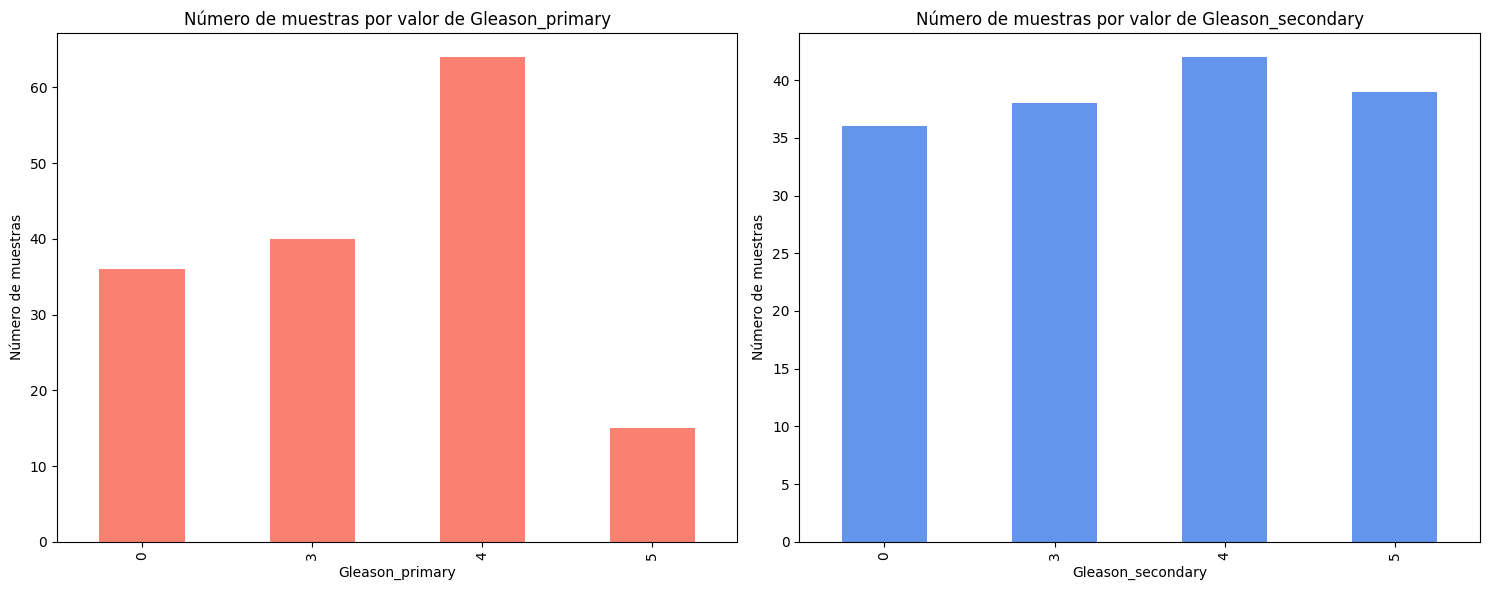

In [ ]:
# Creamos una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras para Gleason_primary
wsi_labels_df['Gleason_primary'].value_counts().sort_index().plot(kind='bar', color='salmon', ax=axes[0])
axes[0].set_xlabel('Gleason_primary')
axes[0].set_ylabel('Número de muestras')
axes[0].set_title('Número de muestras por valor de Gleason_primary')

# Gráfico de barras para Gleason_secondary
wsi_labels_df['Gleason_secondary'].value_counts().sort_index().plot(kind='bar', color='cornflowerblue', ax=axes[1])
axes[1].set_xlabel('Gleason_secondary')
axes[1].set_ylabel('Número de muestras')
axes[1].set_title('Número de muestras por valor de Gleason_secondary')

plt.tight_layout()
plt.show()

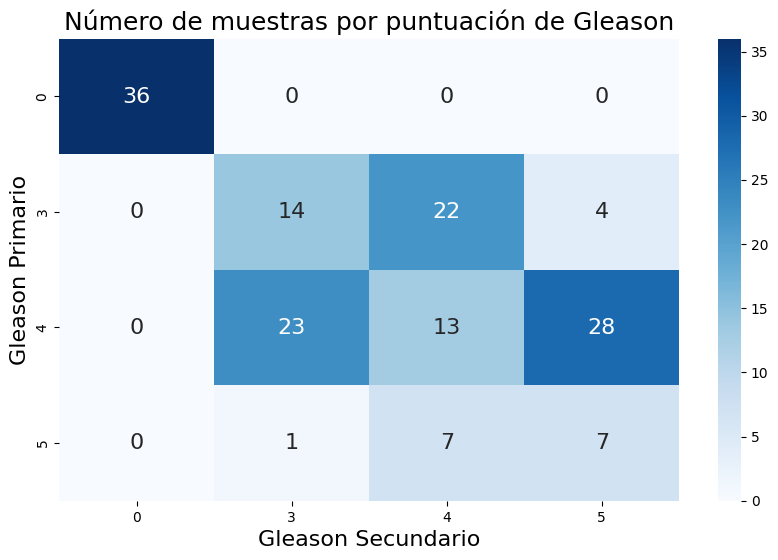

In [ ]:
# Creamos una tabla de contingencia
gleason_table = pd.crosstab(wsi_labels_df['Gleason_primary'], wsi_labels_df['Gleason_secondary'])

# Creamos el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gleason_table, annot=True, cmap="Blues", fmt='g', annot_kws={"size": 16})
plt.title('Número de muestras por puntuación de Gleason', fontsize=18)
plt.xlabel('Gleason Secundario', fontsize=16)
plt.ylabel('Gleason Primario', fontsize=16)
plt.show()

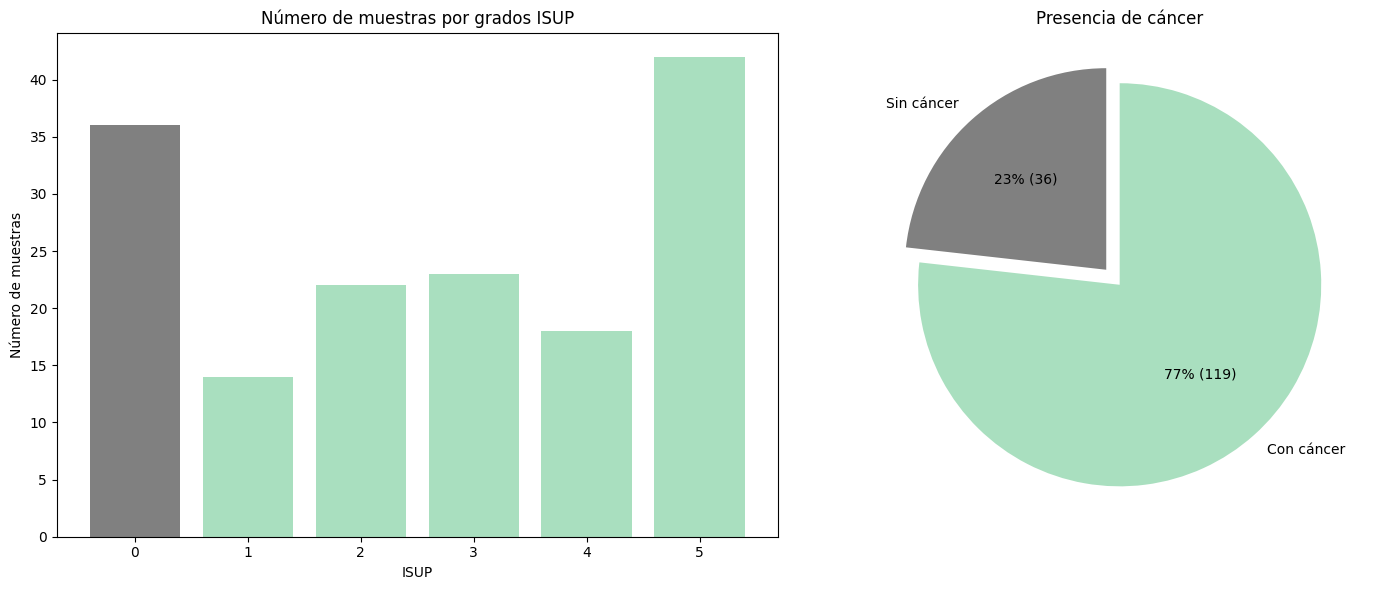

In [ ]:
# Configuración de la figura
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Gráfico de barras para la puntación Isup
gleason_counts = wsi_labels_df['isup'].value_counts().sort_index()
bar_colors = ['gray' if i == 0 else '#A9DFBF' for i in gleason_counts.index]

axes[0].bar(gleason_counts.index, gleason_counts.values, color=bar_colors)
axes[0].set_xlabel('ISUP')
axes[0].set_ylabel('Número de muestras')
axes[0].set_title('Número de muestras por grados ISUP')

# Gráfico de sectores para indicar la presencia o ausencia de cáncer
cancer_counts = wsi_labels_df['cancer_present'].value_counts().sort_index()
labels = ['Sin cáncer', 'Con cáncer']
colors = ['gray', '#A9DFBF']
explode = (0.1, 0)  # esto hace que el segmento 'Sin cáncer' se destaque un poco
autopct = lambda p: '{:.0f}% ({:,.0f})'.format(p, p * sum(cancer_counts) / 100)  # Formato de etiqueta con porcentaje y conteo
axes[1].pie(cancer_counts, labels=labels, colors=colors, explode=explode, autopct=autopct, startangle=90)
axes[1].set_title('Presencia de cáncer')

# Mostramos
plt.tight_layout()
plt.show()

<a name="reconstrucción"></a>
## **Reconstrucción de Whole Slide Images (WSIs)**
([Índice](#indice))

A continuación, abordaremos la reconstrucción de las Whole Slide Images (WSI) a partir de parches individuales. Reconstruir una WSI completa es una tarea recomendable para comprender y analizar la estructura global de una muestra. Para ello, tendremos en cuenta la pertenencia de cada parche a su respectiva slide, la superposición del 50% y las coordenadas de los parches. Para manejar la reconstrucción, haremos uso de funciones de image_utils.py.

In [ ]:
# Librerías
from tqdm import tqdm

# Utilidades de imagen (image_utils.py)
from image_utils import check_image_properties, parse_image_filename, display_patches, construct_wsi, show_resized_image

Comprobación de tamaño y formato de las imágenes y máscaras

In [ ]:
#check_image_properties(images_path)

Parseo del nombre de la imagen

In [ ]:
example_image_parsed = parse_image_filename(example_img_filename)
print(example_image_parsed)

{'slide_id': '16B0008045', 'block_region': 0, 'x_coordinate_block': 3, 'y_coordinate_block': 5, 'xini': 11089, 'yini': 3611}


Visualización de parches y reconstrucción de la imagen completa WSI

Visualización de los parches con slide_id: 16B0008045


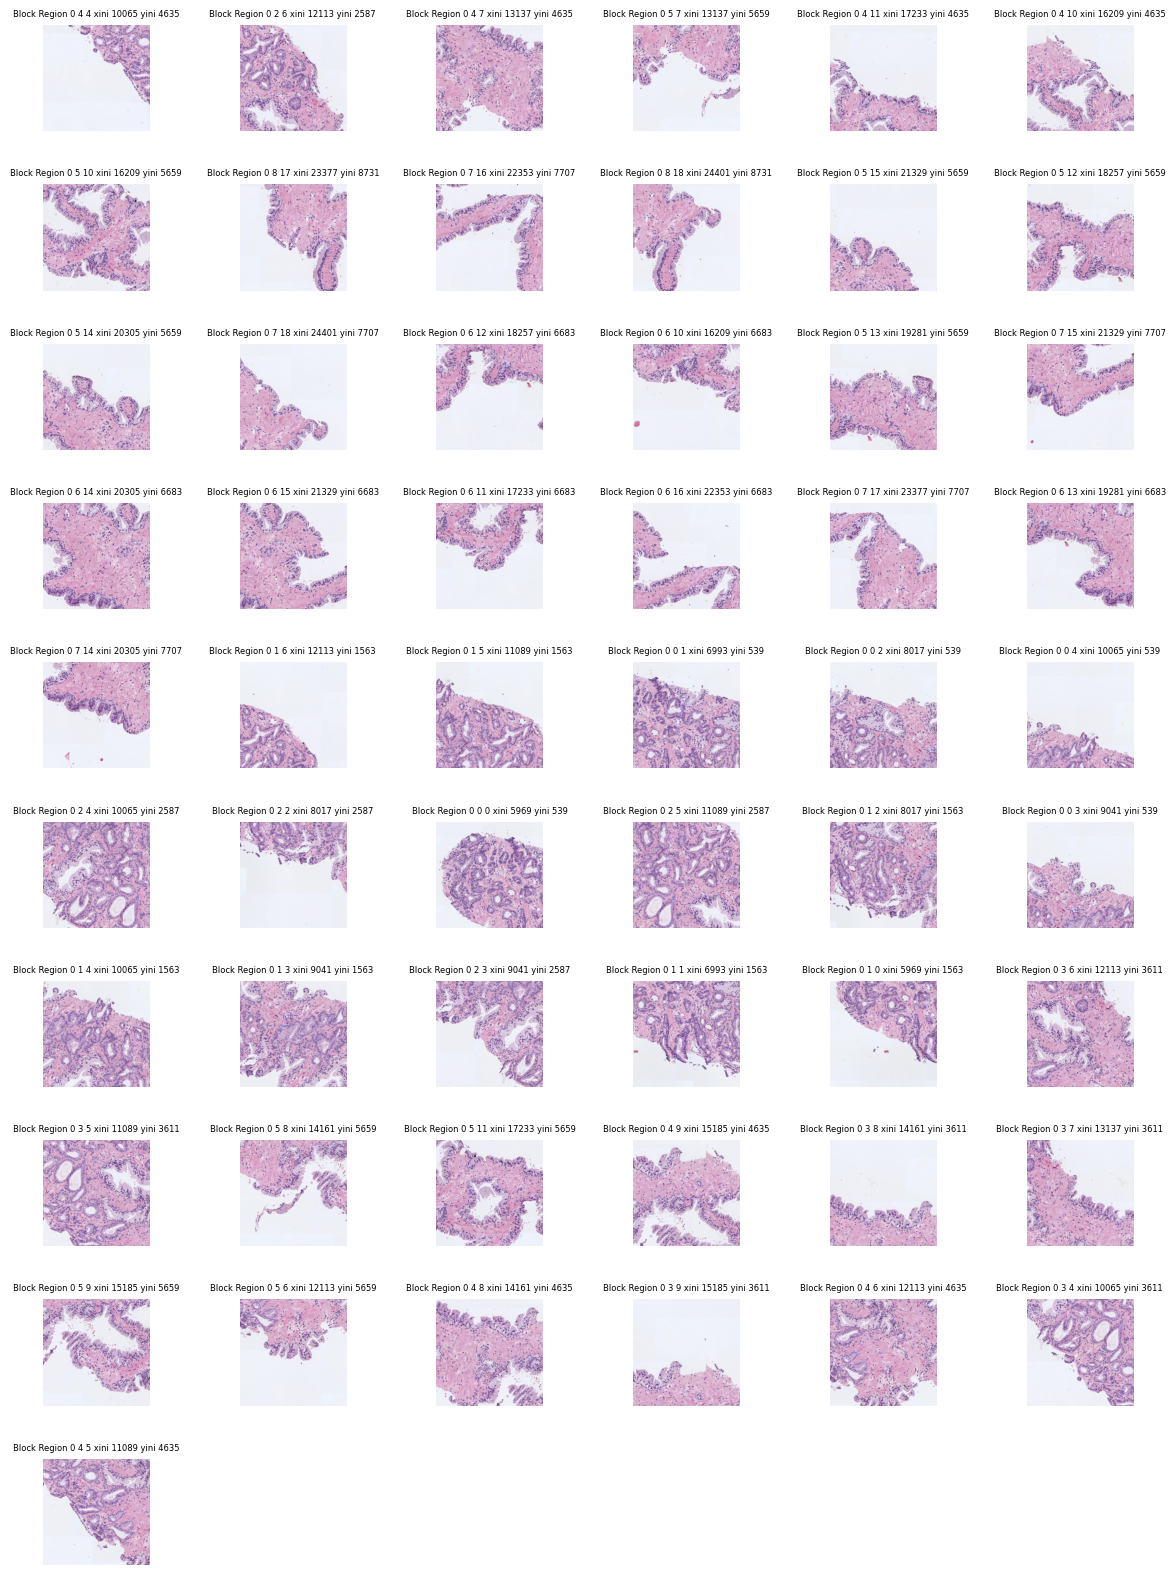

In [ ]:
# Visualización de parches con el mismo slide ID
display_patches(example_image_parsed['slide_id'], images_path, patches_per_row=6)

In [ ]:
# Construcción de la WSI
wsi_image = construct_wsi(example_image_parsed['slide_id'], images_path)

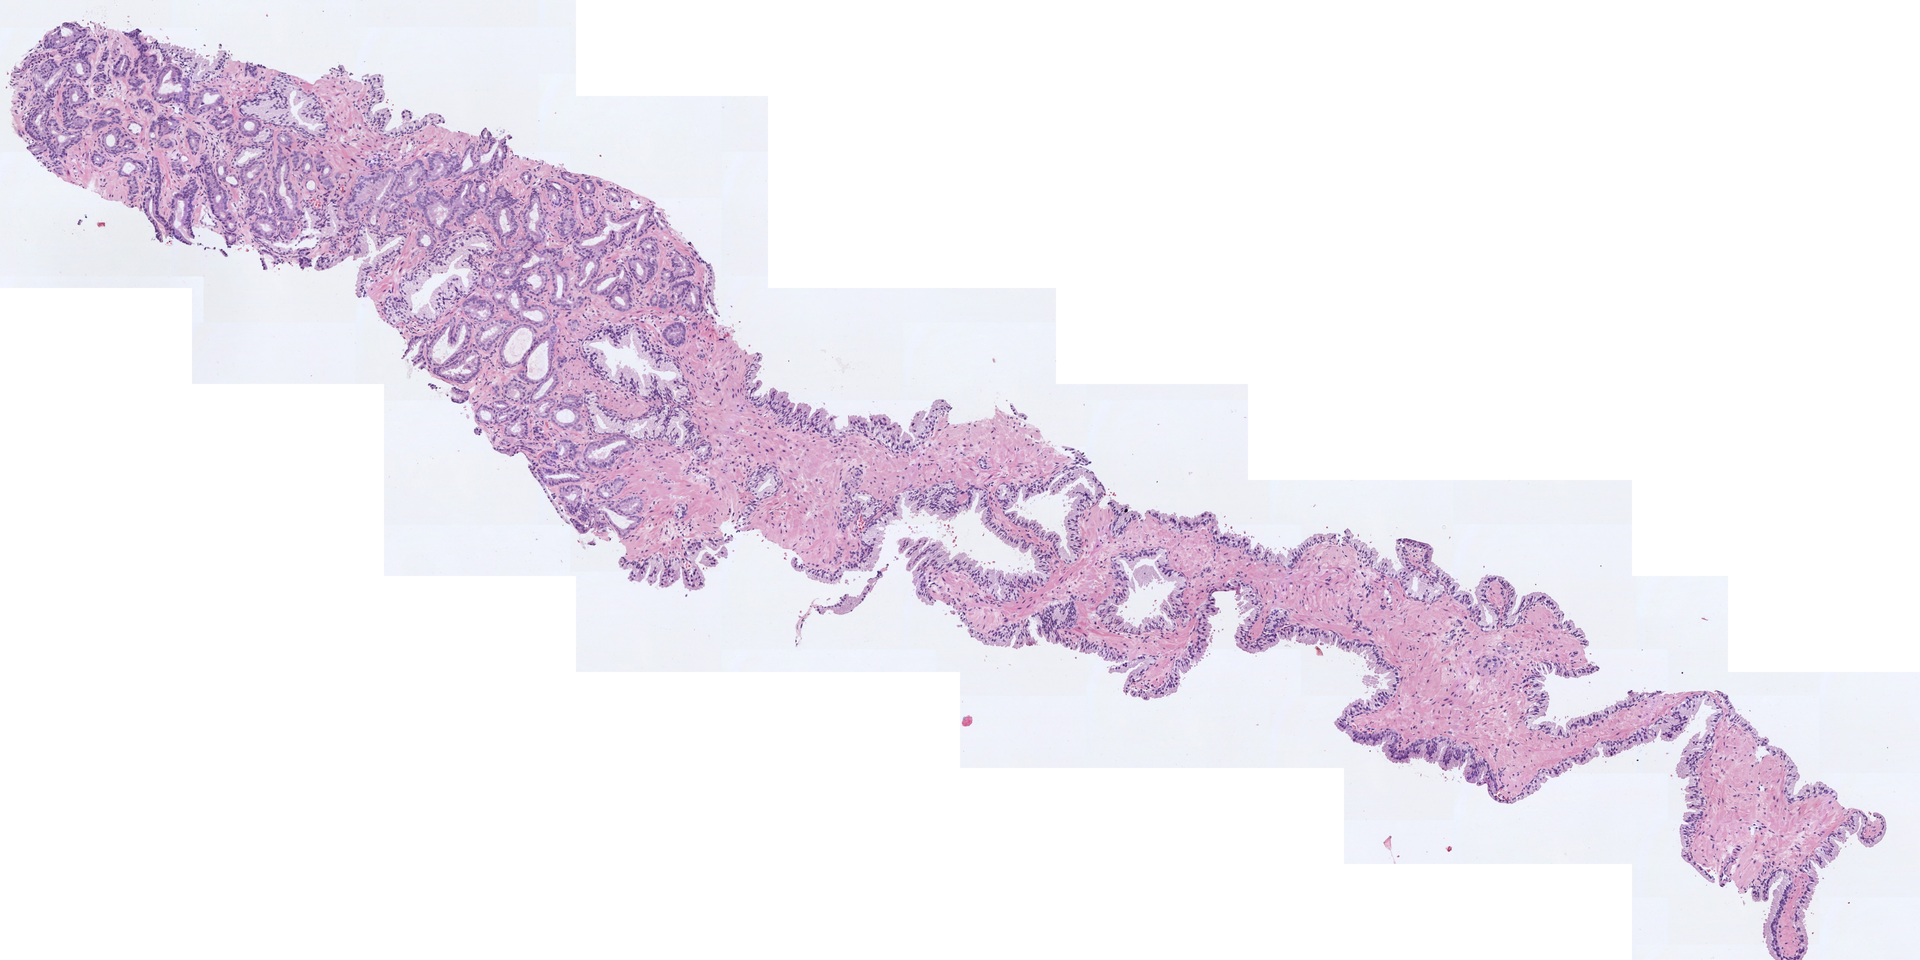

In [ ]:
# Visualización de la imagen completa redimensionada y ajustada
show_resized_image(wsi_image)

In [ ]:
del wsi_image

Reconstrucción de todas las WSI

In [ ]:
# Creamos un nuevo directorio ('data') donde almacenaremos imágenes de elaboración propia
data_path = os.path.join(BASE_FOLDER, 'data')
os.makedirs(data_path, exist_ok=True)

In [ ]:
# Creamos un nuevo directorio ('wsi') donde almacenaremos todas las WSI reconstruidas
wsi_path = os.path.join(data_path, 'wsi')
os.makedirs(wsi_path, exist_ok=True)

In [ ]:
# Obtenemos todos los identificadores de WSI
slide_ids = wsi_labels_df['slide_id'].unique()

# Para cada uno ...
for slide_id in tqdm(slide_ids, desc="Reconstruyendo WSI ... "):
  # Reconstruimos la imagen usando la función construct_wsi
  reconstructed_image = construct_wsi(slide_id, images_path)

  # Verificamos si la imagen fue construida exitosamente
  if reconstructed_image:
    # Guardamos la imagen
    reconstructed_image_path = os.path.join(wsi_path, f"{slide_id}.jpg")
    reconstructed_image.save(reconstructed_image_path)
    #show_resized_image(reconstructed_image)

Reconstruyendo WSI ... : 100%|██████████| 155/155 [37:35<00:00, 14.55s/it]


Detección de errores en WSI

In [ ]:
print("Las siguientes WSI tienen información irregular (parches repetidos, mal posicionamiento, ...): ")
positions = [1,2,3,10,17,19,25,31,42,132,133,148,149,150]
indexes = [pos-1 for pos in positions ]
slide_ids_at_indexes = wsi_labels_df['slide_id'].iloc[indexes]
print(slide_ids_at_indexes)

Las siguientes WSI tienen información irregular (parches repetidos, mal posicionamiento, ...): 
0       16B0001851
1       16B0003388
2       16B0003394
9       16B0022608
16      16B0022786
18      16B0023614
24      16B0026792
30      16B0027040
41      16B0028914
131    18B0005478I
132    18B0005478J
147    18B0006623C
148    18B0006623D
149    18B0006623F
Name: slide_id, dtype: object


In [ ]:
# Eliminamos las filas y reajustamos los índices
wsi_labels_df = wsi_labels_df.drop(indexes).reset_index(drop=True)

<a name="normalización"></a>
### **Normalización de Whole Slide Images (WSIs)**
([Índice](#indice))

En este apartado, nos sumergiremos en el proceso de normalización de tinciones en imágenes histológicas. La normalización busca estandarizar la apariencia de las tinciones, especialmente cuando provienen de laboratorios y escáneres diferentes. Esta estandarización no solo mejora la coherencia visual sino que puede contribuir significativamente a la precisión de los análisis subsiguientes. Utilizaremos la librería 'staintools' para este propósito.

In [ ]:
# Instalación de dependencias
!pip install staintools
!pip install spams

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14048 sha256=fd86d70e292048ac611555af7d552f3b679a0614d1c94383025735aecd5ee869
  Stored in directory: /root/.cache/pip/wheels/83/01/30/d5b79f92442193b7e3229cb20fb8458e765594cc2251f87ae6
Successfully built staintools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp310-cp310-linux_x86_64.whl size=3931991 sha256=6b548ec7dec20dfaa63130fa19f714c8f5e26daec704fd437c2ffd6abc931147
  Stored in directory: /root/.cache/pip/wheels/67/9d/1f/60a6c60785b07ad4f087297f04b723e665a97afcd5112ffb06
Successfully built spams


In [ ]:
# Librerías
from staintools import read_image, StainNormalizer, LuminosityStandardizer
from skimage.io import imsave
from skimage import img_as_ubyte

In [ ]:
# Creamos un nuevo directorio ('wsi_norm') donde almacenaremos todas las WSI reconstruidas
wsi_norm_path = os.path.join(data_path, 'wsi_norm')
os.makedirs(wsi_norm_path, exist_ok=True)

In [ ]:
# Ruta de la imagen para normalización
target_image_path = os.path.join(wsi_path, "18B0003896D.jpg")

In [ ]:
# Leemos la imagen objetivo
target_image = read_image(target_image_path)

# Creamos un normalizador indicando el método
#normalizer = StainNormalizer(method='vahadane')
normalizer = StainNormalizer(method='macenko')

# Ajustamos el normalizador al objetivo
normalizer.fit(target_image)

# Listamos las imágenes WSI sin normalizar
wsi_files = [f for f in os.listdir(wsi_path) if f.endswith('.jpg')]

# Para cada WSI ...
for wsi_file in tqdm(wsi_files, desc="Normalizando WSI ..."):

  # Leemos la imagen
  wsi_full_path = os.path.join(wsi_path, wsi_file)
  wsi_image = read_image(wsi_full_path)

  # Estandarizamos el brillo (opcional, puede mejorar el cálculo de la máscara de tejido)
  wsi_image = LuminosityStandardizer.standardize(wsi_image)
  target_image = LuminosityStandardizer.standardize(target_image)

  # Normalizamos la imagen
  norm_image = normalizer.transform(wsi_image)

  # Guardamos la imagen normalizada
  slide_id = wsi_file.split('.')[0]
  output_path = os.path.join(wsi_norm_path, f"{slide_id}.jpg")
  imsave(output_path, img_as_ubyte(norm_image))

Normalizando WSI ...: 100%|██████████| 155/155 [1:26:55<00:00, 33.65s/it]


<a name="nuevos_parches"></a>
## **Generación de nuevos parches sin superposición**
([Índice](#indice))

En la base de datos SICAPv2, los parches de imágenes se superponen en un 50% de manera inherente. Si bien esta superposición permite una transición más suave entre imágenes, también introduce una redundancia considerable en los datos. Esta repetición, puede inducir al modelo a una mala generalización. Para combatir este desafío, decidimos generar nuevos parches basándonos en las WSI reconstruidas. Estos parches serán de dimensiones reducidas, 256x256 en lugar de los 512x512 originales. La reducción en tamaño se debe a que con los parches originales encontramos que sus representaciones eran voluminosas y, en consecuencia, más difíciles de procesar.

In [ ]:
# Librerías
import cv2

# Utilidades de imágenes (image_utils)
from image_utils import extract_tissue_mask, extract_patches

In [ ]:
# Creamos un nuevo directorio ('masks') donde almacenaremos todas las máscaras de WSI
wsi_masks_path = os.path.join(data_path, 'masks')
os.makedirs(wsi_masks_path, exist_ok=True)

In [ ]:
# Creamos un nuevo directorio ('images') donde almacenaremos todas los parches
wsi_patches_path = os.path.join(data_path, 'images')
os.makedirs(wsi_patches_path, exist_ok=True)

In [ ]:
# Lista de imágenes WSI
wsi_images = [f for f in os.listdir(wsi_norm_path) if f.endswith('.jpg')]

# Extramos la máscara y todos los parches de cada WSI
for wsi in tqdm(wsi_images, desc="Extrayendo máscaras y parches ... "):
    # Cargamos imagen
    image_path = os.path.join(wsi_norm_path, f"{wsi}")
    image = cv2.imread(image_path)

    # Extraemos y guardamos máscara
    tissue_mask = extract_tissue_mask(image)
    slide_id = wsi.rsplit('.', 1)[0]
    mask_save_path = os.path.join(wsi_masks_path, f"{slide_id}.jpg")
    cv2.imwrite(mask_save_path, tissue_mask)

    # Extraemos parches
    patch_size = 256
    tissue_threshold=0.2
    extract_patches(slide_id, image, tissue_mask, wsi_patches_path, patch_size, tissue_threshold)

Extrayendo máscaras y parches ... : 100%|██████████| 155/155 [04:14<00:00,  1.64s/it]


In [ ]:
# Transformaciones para parches
transform_patches = transforms.Compose([
    transforms.ToTensor(),                                                        # Normalizamos y transformamos a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Estandarización (solo para redes preentrenadas con ImageNet)
])

patches_dataset = SlideDataset(wsi_patches_path, transform_patches)

In [ ]:
# Número de elementos del conjunto
print(f'El conjunto de datos tiene {len(patches_dataset)} parches')

El conjunto de datos tiene 18791 parches


<a name="latente"></a>
## **Representación de nodos y extracción de características de parches**
([Índice](#indice))

Llegados a este punto, exploraremos cómo obtener la representación latente de los parches. Esta representación supone la transformación de las características originales en un espacio de menor dimensión que captura de manera efectiva las características más relevantes.

In [ ]:
# Intalación de dependencias
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.1 MB/s eta 0:00:00


In [ ]:
# Librerías
import torch
from torchsummary import summary
from torch.utils.data import random_split
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import torch.nn as nn

# Utilidades de extracción de características (feature_extractor.py)
from feature_extractor import PatchEmbeddingPretrained, PatchEmbeddingUNet

Definición de la arquitectura preentrenada

In [ ]:
# Establecemos el dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Creamos una instancia del modelo
model_name = 'PANDA_ConvNeXT'
PatchEmbeddingPretrainedModel = PatchEmbeddingPretrained(model_name, device)

# Movemos el modelo al dispositivo
PatchEmbeddingPretrainedModel.to(device)

# Obtenemos las dimensiones de la imagen
input_size = patches_dataset[0]["image"].shape
print(f'Dimensión de las imágenes de entrada: {input_size}')

if model_name == 'PANDA_ConvNeXT':
  print(PatchEmbeddingPretrainedModel)
else:
  summary(PatchEmbeddingPretrainedModel, input_size=input_size)

Dimensión de las imágenes de entrada: torch.Size([3, 256, 256])
PatchEmbeddingPretrained(
  (pretrained_model): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 

In [ ]:
# Representación latente de un parche
random_img_representation = PatchEmbeddingPretrainedModel.get_latent_representation(to_pil_image(patches_dataset[0]['image']))

print(random_img_representation.shape)

torch.Size([2048, 8, 8])


In [ ]:
del random_img_representation

Definición de la arquitectura U-Net

In [ ]:
# Establecemos el dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Creamos una instancia del modelo
PatchEmbeddingUNetModel = PatchEmbeddingUNet([64,128,256,512,1024], device)

# Movemos el modelo al dispositivo
PatchEmbeddingUNetModel.to(device)

# Obtenemos las dimensiones de la imagen
input_size = patches_dataset[0]["image"].shape
print(f'Dimensión de las imágenes de entrada: {input_size}')

summary(PatchEmbeddingUNetModel, input_size=input_size)

Dimensión de las imágenes de entrada: torch.Size([3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]         147,584
              ReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
             ReLU-10          [-1, 256, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         590,080
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 512,

In [ ]:
# Seleccionamos las imágenes que usaremos para el entrenamiento
random_indexes = random.sample(range(len(patches_dataset)), 1000)
selected_slides = [patches_dataset[i] for i in random_indexes]

In [ ]:
# Establecemos una semilla
torch.manual_seed(123)

# Definimos el tamaño de lote
batch_size = 16

# Definimos el tamaño de los conjuntos de entrenamiento, validación y test
dataset_size = len(selected_slides)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

# Dividimos en conjuntos de entrenamiento, validación y test
train_dataset, val_dataset = random_split(selected_slides, [train_size, val_size])

# Creamos DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Epoch [1/15] - train_loss: 0.0228 - train_PSNR: 18.7195 - train_SSIM: 0.7316 - val_loss: 0.0038 - val_PSNR: 24.2905 - val_SSIM: 0.8826
Epoch [2/15] - train_loss: 0.0025 - train_PSNR: 26.2831 - train_SSIM: 0.9147 - val_loss: 0.0016 - val_PSNR: 27.9962 - val_SSIM: 0.9381
Epoch [3/15] - train_loss: 0.0015 - train_PSNR: 28.3492 - train_SSIM: 0.9428 - val_loss: 0.0012 - val_PSNR: 29.2251 - val_SSIM: 0.9499
Epoch [4/15] - train_loss: 0.0011 - train_PSNR: 29.8389 - train_SSIM: 0.9560 - val_loss: 0.0012 - val_PSNR: 29.2758 - val_SSIM: 0.9612
Epoch [5/15] - train_loss: 0.0008 - train_PSNR: 31.0316 - train_SSIM: 0.9652 - val_loss: 0.0007 - val_PSNR: 31.5467 - val_SSIM: 0.9707
Epoch [6/15] - train_loss: 0.0006 - train_PSNR: 32.4406 - train_SSIM: 0.9723 - val_loss: 0.0006 - val_PSNR: 32.5784 - val_SSIM: 0.9761
Epoch [7/15] - train_loss: 0.0005 - train_PSNR: 33.0378 - train_SSIM: 0.9777 - val_loss: 0.0005 - val_PSNR: 33.4218 - val_SSIM: 0.9819
Epoch [8/15] - train_loss: 0.0003 - train_PSNR: 34.8709

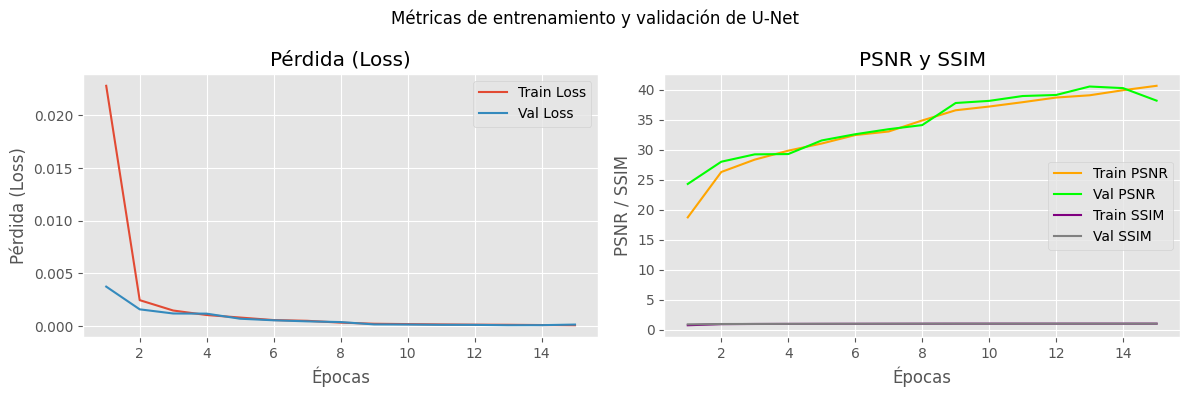

In [ ]:
# Definimos el criterio
criterion = nn.MSELoss()

# Definimos el optimizador
learning_rate = 0.001 # Para representación latente de RGB
optimizer = optim.Adam(PatchEmbeddingUNetModel.parameters(), lr=learning_rate)

# Entrenamos el modelo
PatchEmbeddingUNetModel.train_model(train_loader, val_loader, optimizer, criterion, num_epochs=15)

Guardamos y cargamos los pesos del modelo

In [ ]:
weights_folder = os.path.join(BASE_FOLDER, 'Models_Weights')

In [ ]:
torch.save(PatchEmbeddingUNetModel.state_dict(), os.path.join(weights_folder, 'U-Net_weights.pth') )

In [ ]:
PatchEmbeddingUNetModel.load_state_dict(torch.load(os.path.join(weights_folder, 'U-Net_weights.pth')))
PatchEmbeddingUNetModel.to(device)

PatchEmbeddingUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (center): Sequential(
    (0): Conv2d(51

In [ ]:
# Representación latente de un parche
random_img_representation = PatchEmbeddingUNetModel.get_latent_representation(to_pil_image(patches_dataset[0]['image']))
print(random_img_representation.shape)

torch.Size([1024, 16, 16])


In [ ]:
del random_img_representation

Obtención de representaciones latentes

In [ ]:
# Escogemos el modelo para la representación latente de todos los parches

# Red preentrenada:
latent_representations = PatchEmbeddingPretrainedModel.get_all_latent_representation(patches_dataset, batch_size=32, num_workers=4)

# U-Net:
#latent_representations = PatchEmbeddingUNetModel.get_all_latent_representation(patches_dataset, batch_size=32, num_workers=4)

Procesando lotes ...: 100%|██████████| 588/588 [19:08<00:00,  1.95s/batch]


In [ ]:
# Accedemos al primer elemento
first_representation_name = next(iter(latent_representations.keys()))
first_latent_representation = latent_representations[first_representation_name]
print(f'Primer nombre de archivo: {first_representation_name}')
print(f'Primera representación latente: {first_latent_representation}')

Primer nombre de archivo: 18B0006621D_Block_Region_0_6_2_xini_512_yini_1536.jpg
Primera representación latente: tensor([[[-1.1307e+00, -1.0036e+00, -9.1660e-01,  ...,  6.7716e+00,
           1.9699e+00,  9.1189e-01],
         [-1.3747e+00, -1.2638e+00, -2.8054e-01,  ...,  3.1620e+00,
           3.5596e+00, -2.4329e+00],
         [-1.4132e+00, -7.5072e-01, -9.9729e-01,  ..., -2.3718e+00,
          -8.3824e+00,  4.6806e+00],
         ...,
         [-1.2312e+00, -1.1120e+00,  6.7236e-03,  ..., -7.2696e+00,
          -5.8779e+00, -5.3017e+00],
         [-1.3377e+00, -1.8553e+00, -1.9367e-01,  ..., -4.2831e+00,
          -2.4785e+00,  4.7523e+00],
         [-1.1072e+00, -1.7503e+00, -6.4481e-01,  ..., -1.5897e+00,
          -3.4480e+00, -2.8232e+00]],

        [[-1.4417e-02,  1.5846e-01,  1.5415e-01,  ...,  2.9773e+00,
           8.1916e-01,  3.4109e-01],
         [-6.1497e-03,  1.0877e-01,  3.9541e-02,  ..., -2.6589e+00,
          -6.8851e+00, -9.8579e-01],
         [ 1.3072e-01,  9.0691e-

Eliminamos las referencias y limpiamos la memoria

In [ ]:
#del PatchEmbeddingPretrainedModel
#del PatchEmbeddingUNetModel
#del random_indexes, selected_slides, train_dataset, val_dataset, train_loader, val_loader

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

99

<a name="construcción_grafos"></a>
## **Construcción de grafos mediante PyTorch Geometric**
([Índice](#indice))

Existen librerías como networkx que sirven para la construcción y visualización de grafos, definiendo de manera sencilla los nodos y las aristas. En nuestro caso, esta construcción es más compleja ya que tenemos que incluir las representaciones latentes y otras características. En este sentido, utilizaremos la librería PyTorch Geometric, dado que permite una transición más suave a la hora de utilizar Redes Neuronales de Grafos (GNN).

**PyTorch Geometric** (PyG) es una extensión de la popular librería de aprendizaje profundo PyTorch, diseñada específicamente para trabajar con datos estructurados, como grafos y datos espaciales.

PyG ofrece una colección diversa de representaciones de grafos, transformaciones de datos, capas de redes neuronales y modelos para trabajar con datos de grafos.

[Documentación PyTorch Geometric](https://pytorch-geometric.readthedocs.io/)

Durante este proceso, cada nodo quedará caracterizado por su representación latente, agregando profundidad y significado al grafo. De esta manera, sentaremos una base sólida para la aplicación de técnicas de GNN en la estructura del grafo.

Cabe mencionar que se han diseñado las funciones de manera flexible. Esta flexibilidad nos permite abordar la creación del grafo desde dos enfoques:

*   Grafo con conexiones entre todos los nodos (incluyendo la distancia como atributo en las aristas)
*   Region Adjacency Graph (RAG)

In [ ]:
# Instalación de dependencias
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.7 MB/s eta 0:00:00


In [ ]:
# Librerías
from PIL import Image

# Utilidades de grafos (graph_utils.py)
from graph_utils import construct_graph, visualize_graph

WSI con slide_id 16B0008045

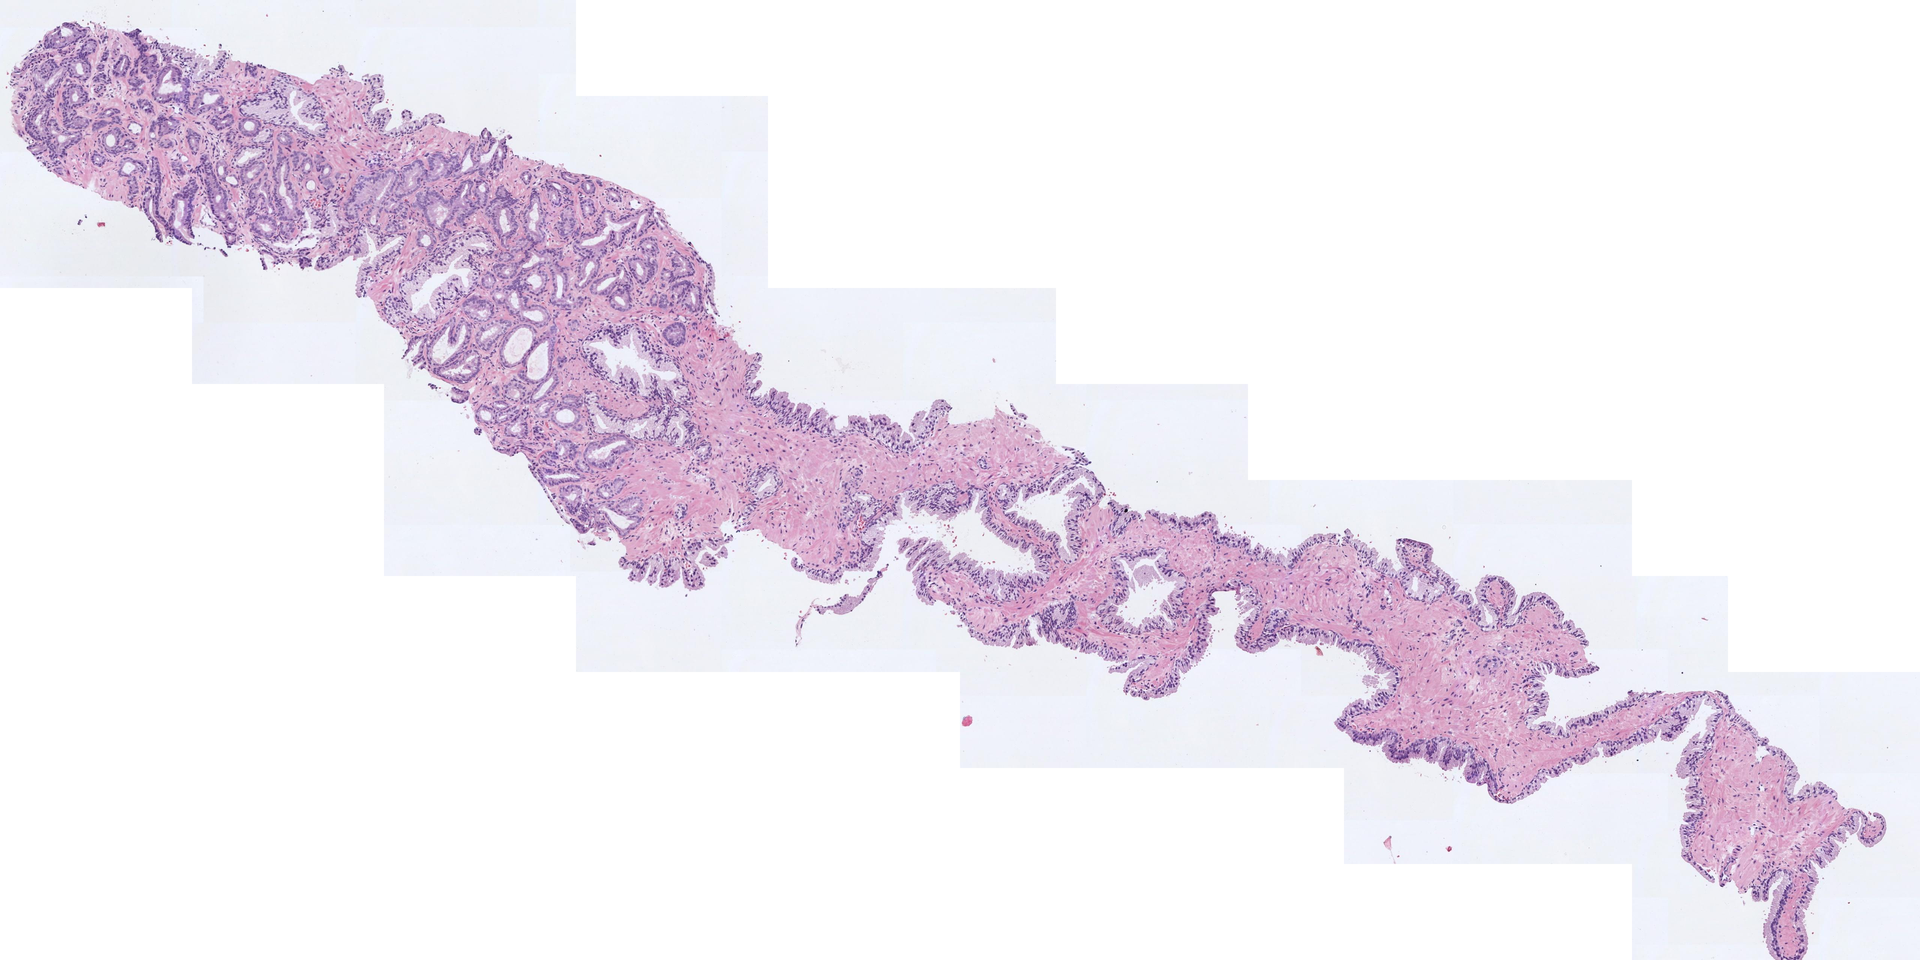

In [ ]:
show_resized_image(Image.open(os.path.join(wsi_path, example_image_parsed['slide_id'] + ".jpg")))

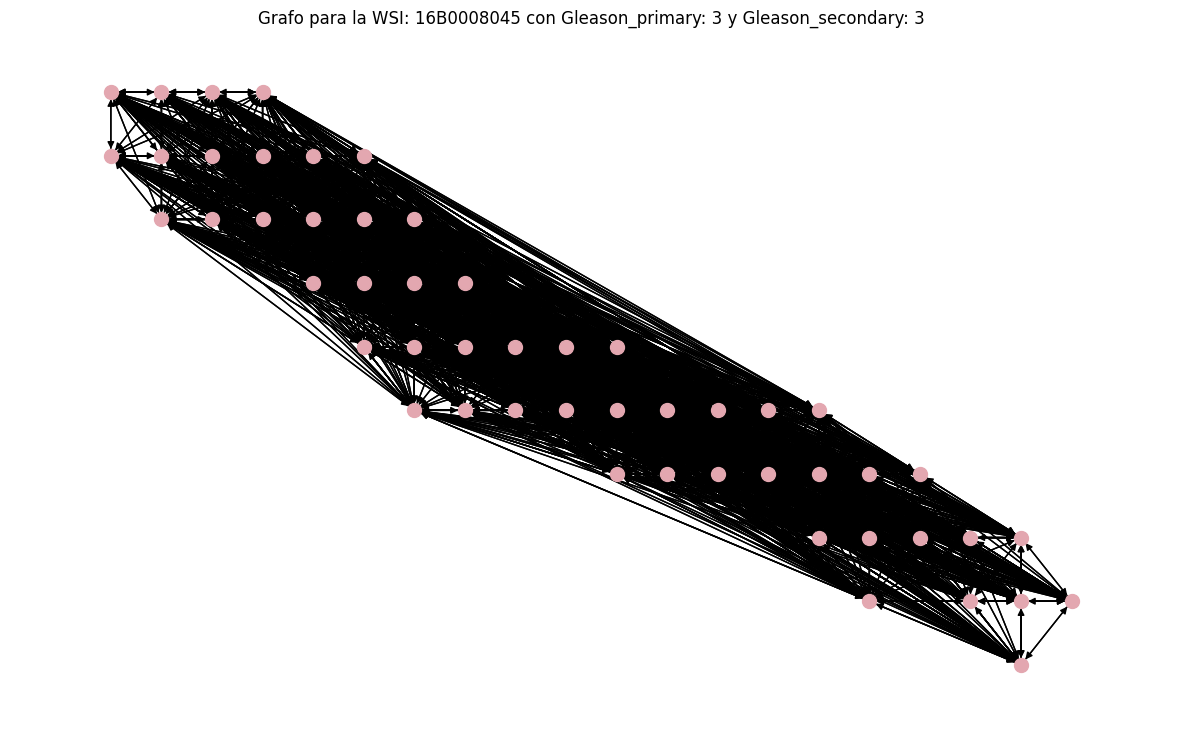

In [ ]:
# Construimos el grafo con todas las conexiones
graph = construct_graph(example_image_parsed['slide_id'], wsi_patches_path , wsi_labels_df, latent_representations, device)

# Visualizamos el grafo
visualize_graph(graph)

In [ ]:
del graph

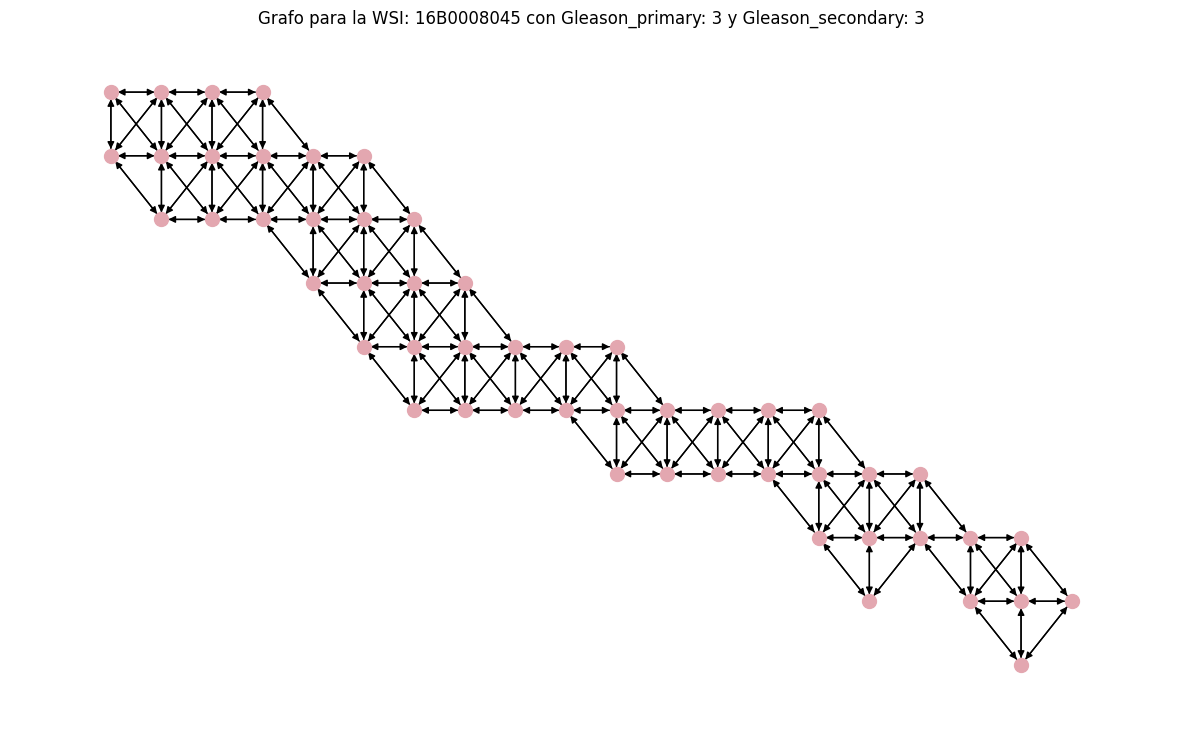

In [ ]:
# Construimos el RAG (ejemplo conexo)
graph = construct_graph(example_image_parsed['slide_id'], wsi_patches_path , wsi_labels_df, latent_representations, device, only_contiguous=True, threshold=363)

# Visualizamos el grafo
visualize_graph(graph)

In [ ]:
del graph

WSI con slide_id 16B0022781

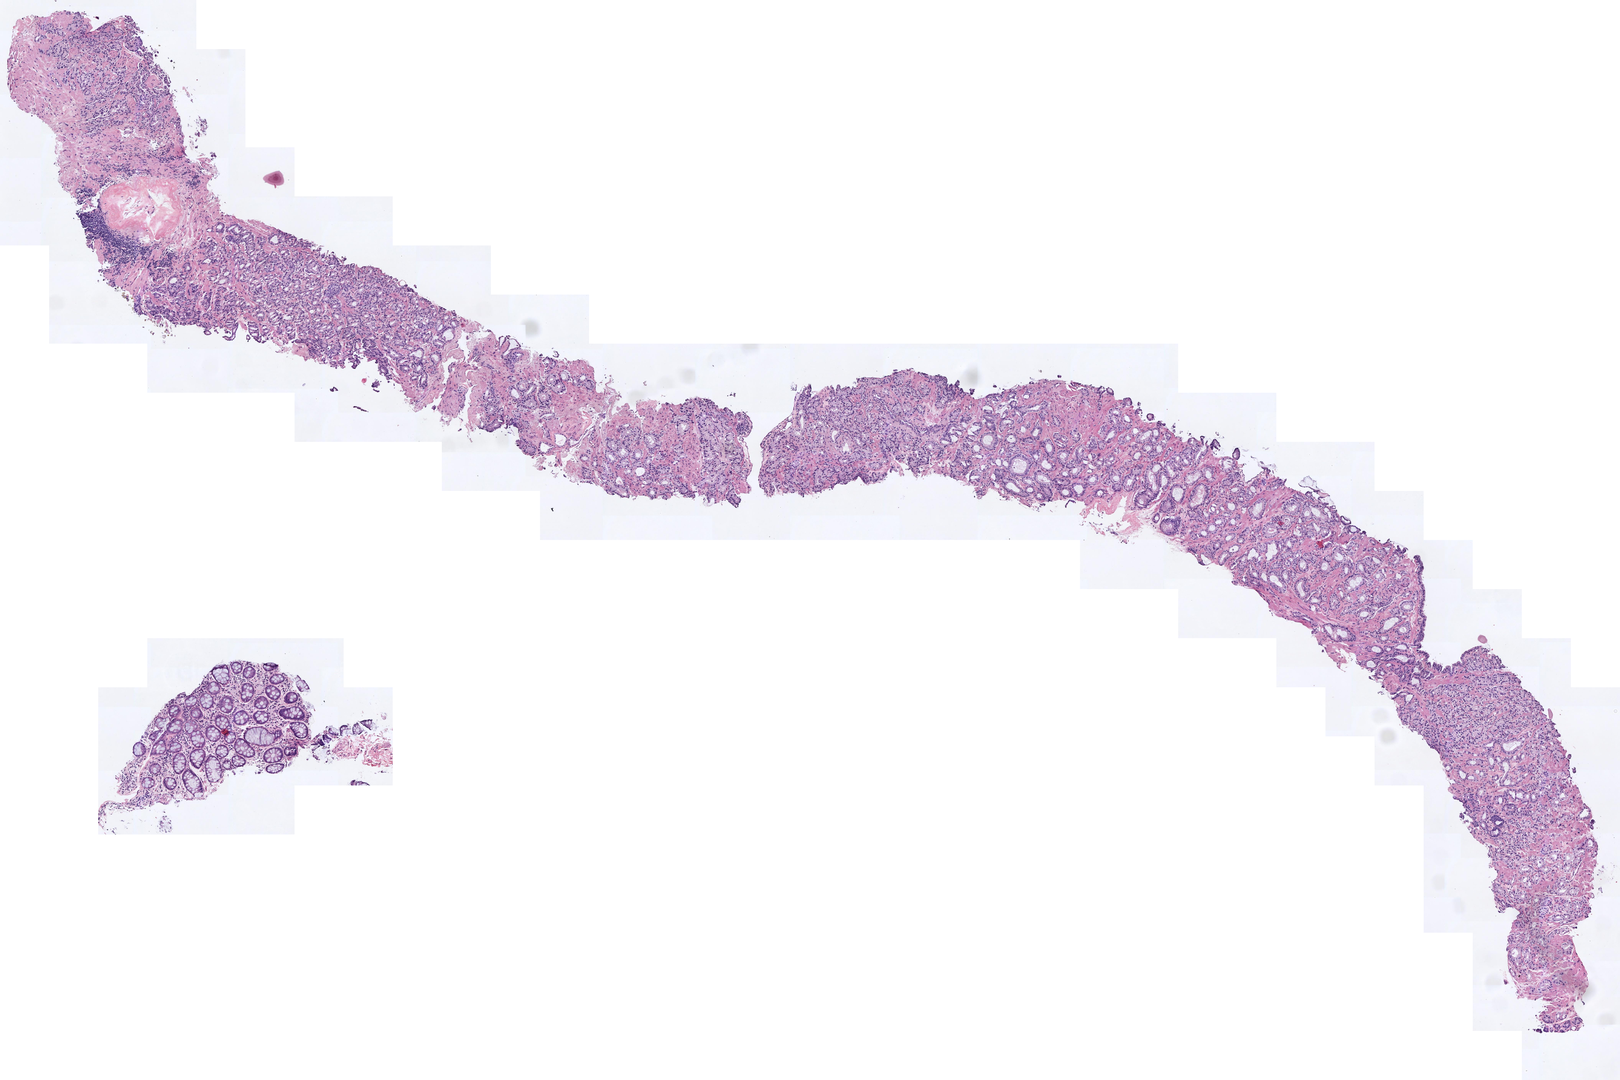

In [ ]:
show_resized_image(Image.open(os.path.join(wsi_path, "16B0022781.jpg")))

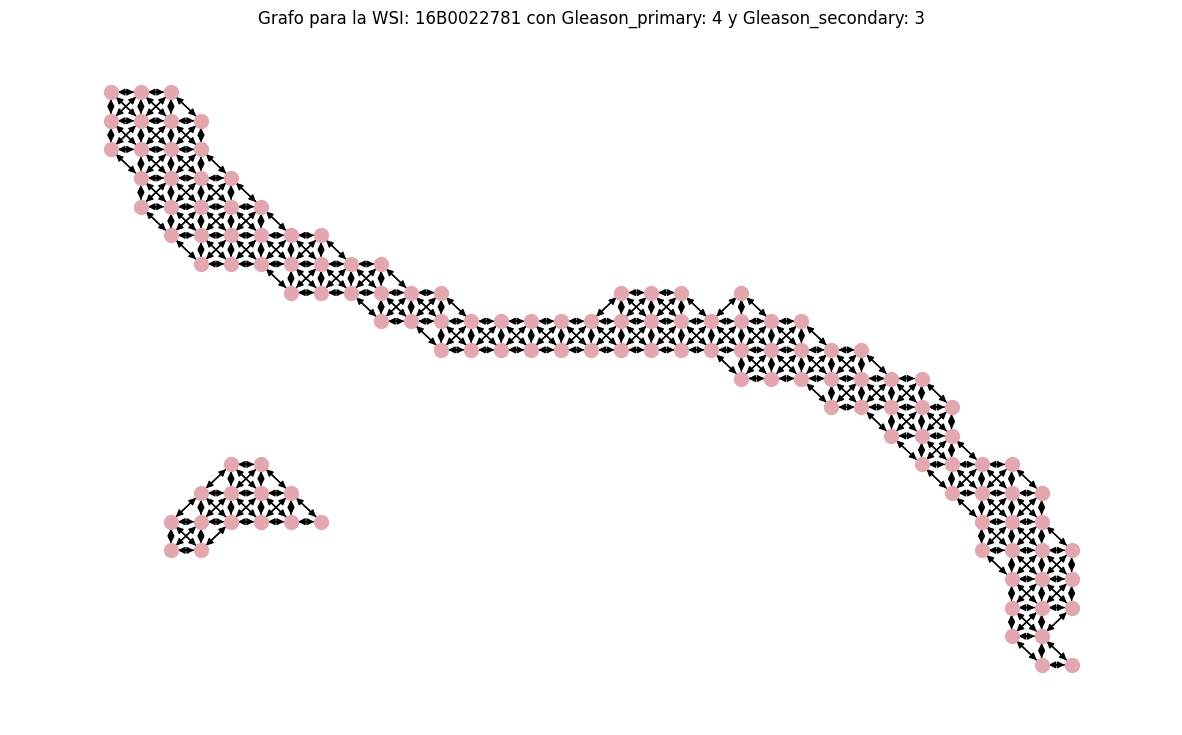

In [ ]:
# Construimos el RAG (ejemplo no conexo)
graph = construct_graph('16B0022781', wsi_patches_path , wsi_labels_df, latent_representations, device, only_contiguous=True, threshold=363)

# Visualizamos el grafo
visualize_graph(graph)

In [ ]:
del graph

Para calcular el valor del threshold óptimo, hay que tener en cuenta que dos parches contiguos están a una distancia equivalente al tamaño del parche. Por desigualdad triangular, dos parches diagonales están a:



In [ ]:
import math

print(math.sqrt(256**2+256**2))

362.03867196751236


<a name="Generación"></a>
## **Generación del conjunto de datos de grafos**
([Índice](#indice))

In [ ]:
# Librerías
import torch
from collections import defaultdict
import random
from torch.utils.data import Subset
from torch_geometric.data import Batch

# Clase GraphDataset (graph_dataset.py)
from graph_dataset import GraphDataset

In [ ]:
# Creamos el dataset de grafos con un enfoque RAG
sicapv2_graph_dataset = GraphDataset(wsi_labels_df, wsi_patches_path, device, latent_representations, rag=True)

Generando grafos ...: 100%|██████████| 141/141 [10:48<00:00,  4.60s/slide]


In [ ]:
# Comprobación de la generación del dataset
print(f'Dataset: {sicapv2_graph_dataset}:')
print('=============================================================')
print(f'Número de grafos del dataset: {len(sicapv2_graph_dataset)}')

print('\n')

# Tomamos el primer grafo
first_graph = sicapv2_graph_dataset[0]
print(f'Primer grafo: {first_graph}')
print('=============================================================')
print(f'Número de características: {first_graph.num_features}')
print(f'Número de nodos: {first_graph.num_nodes}')
print(f'Número de aristas: {first_graph.num_edges}')
print(f'Media del grado del nodo: {first_graph.num_edges / first_graph.num_nodes:.2f}')
print(f'¿Tiene nodos que se conectan consigo mismo? {first_graph.has_self_loops()}')
print(f'¿Es dirigido? {first_graph.is_directed()}')

Dataset: <graph_dataset.GraphDataset object at 0x786ebbb4ad40>:
Número de grafos del dataset: 141


Primer grafo: Data(x=[119, 2048, 8, 8], edge_index=[2, 706], edge_attr=[706], pos=[119, 2], slide_id='16B0006668', gleason_primary=5, gleason_secondary=5, isup=5)
Número de características: 8
Número de nodos: 119
Número de aristas: 706
Media del grado del nodo: 5.93
¿Tiene nodos que se conectan consigo mismo? False
¿Es dirigido? False


Partición balanceada del conjunto de datos

In [ ]:
# Establece una semilla para garantizar la reproducibilidad
torch.manual_seed(12345)
random.seed(12345)

# Reordena los elementos aleatoriamente
indices = list(range(len(sicapv2_graph_dataset)))
random.shuffle(indices)
sicapv2_graph_subset = Subset(sicapv2_graph_dataset, indices)

# Identificamos todas las combinaciones únicas y creamos una lista de índices para cada combinación
label_to_indices = defaultdict(list)

for idx, data in enumerate(sicapv2_graph_subset):
    label = str(data.gleason_primary) + "+" + str(data.gleason_secondary)
    label_to_indices[label].append(idx)

# Dividimos los índices de manera balanceada
train_indices, val_indices, test_indices = [], [], []

for _, indices in label_to_indices.items():
    total = len(indices)
    train_end = int(0.64 * total)
    val_end = train_end + int(0.16 * total)

    train_indices.extend(indices[:train_end])
    val_indices.extend(indices[train_end:val_end])
    test_indices.extend(indices[val_end:])

# Usamos los índices para crear conjuntos balanceados
train_dataset = Subset(sicapv2_graph_subset, train_indices)
val_dataset = Subset(sicapv2_graph_subset, val_indices)
test_dataset = Subset(sicapv2_graph_subset, test_indices)

# Definimos el Batch_size
batch_size=8 # Cambiar en función de la tarea

# Creamos DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=Batch.from_data_list)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=Batch.from_data_list)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=Batch.from_data_list)

Partición sin balancear


In [ ]:
"""
# Establece una semilla para garantizar la reproducibilidad
#torch.manual_seed(12345)
#random.seed(12345)

# Reordena los elementos aleatoriamente
indices = list(range(len(sicapv2_graph_dataset)))
random.shuffle(indices)

# Dividimos los índices para crear conjuntos de entrenamiento, validación y prueba
total = len(indices)
train_end = int(0.64 * total)
val_end = train_end + int(0.16 * total)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

# Usamos los índices para crear conjuntos
train_dataset = Subset(sicapv2_graph_dataset, train_indices)
val_dataset = Subset(sicapv2_graph_dataset, val_indices)
test_dataset = Subset(sicapv2_graph_dataset, test_indices)

# Definimos el Batch_size
batch_size = 8  # Cambiar en función de la tarea

# Creamos DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=Batch.from_data_list)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=Batch.from_data_list)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=Batch.from_data_list)
"""

<a name="augmentation"></a>
## **Graph augmentation**
([Índice](#indice))

El aumento de datos, comúnmente utilizado en el procesamiento de imágenes, ha demostrado ser una técnica valiosa para mejorar la generalización de los modelos. En el contexto de los grafos, el concepto se traduce en el Graph Augmentation, una técnica que busca diversificar el conjunto de entrenamiento mediante la generación de versiones modificadas de grafos originales.

Pese a que la implementación es opcional, ofrece ventajas en la mitigación del sobreajuste, especialmente en escenarios donde el conjunto de datos es limitado o desequilibrado. En el fichero graph_augmentation.py se han desarrollado algunos métodos que incluyen ruido gaussiano, eliminación aleatoria de aristas y técnicas de sobremuestreo adaptativo.

Se han experimentado con estas técnicas como un enfoque exploratorio, para ver su impacto en el rendimiento. Es crucial mencionar que dado que la base de datos está altamente desbalanceada, ciertas clases o categorias están representadas por 1, 4 o 7 imágenes, nos enfrentamos a un desafío intrínseco a la naturaleza de los datos. A pesar de paliar estas carencias mediante técnicas de sobremuestreo adaptativo, la carencia inicial de datos podría hacer que no sean suficientes.

In [ ]:
# Utilidades para el aumento de datos
from graph_augmentation import augment_graph_dataset, adaptive_minority_over_sampling

In [ ]:
# Uso del código
augmented_train_dataset = adaptive_minority_over_sampling(train_dataset, sigma=0.15, drop_probability=0.3)

In [ ]:
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

<a name="Modelo"></a>
## **Construcción, entrenamiento y evaluación del modelo GNN**
([Índice](#indice))

El modelo implementado en la clase SegGiniGraphHead se basa en la arquitectura Graph Isomorphism Network (GIN) ([Learning Whole-Slide Segmentation from Inexact
and Incomplete Labels using Tissue Graphs](https://arxiv.org/pdf/2103.03129.pdf)).

Cada capa GIN se compone de varias subcapas, incluyendo capas lineales, normalización por lotes, ReLU y dropout. Esta clase ofrece gran versatilidad, pudiendo construir diferentes modelos modificando el número de capas GINConv, número de capas ocultas, uso de batch normalization y dropout, aplicación de pooling promedio o aplanamiento para las características de los nodos, ... Además, permite definir la salida deseada en función del próposito. Según el modo configurado (gleason o isup), la red puede producir dos salidas (para los grados de Gleason primario y secundario) o una única salida para el grado ISUP.

In [ ]:
# Liberías
from torch.optim.lr_scheduler import ExponentialLR

# Modelo GIN (models.py)
from models import SegGiniGraphHead

# Entrenamiento y validación (train.py)
from train_model import train_validate_gleason, train_validate_sum_gleason, train_validate_isup, train_validate_cancer_present

# Evaluación del rendimiento (test.py)
from test_model import test_gleason, test_sum_gleason, test_isup, test_cancer_present

In [ ]:
# Definimos el dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

**Detección de cáncer**

In [ ]:
# Definimos el número de características, canales ocultos, número de clases, ..
num_gin_layers = 1
num_features = 2048
hidden_dim = [32,32]
num_classes = 2 # Clasificación binaria 0,1
gin_dropout_rates = [0]
final_dropout_rate = 0
use_batch_norms = [False]
mode = "isup"
use_global_avg_pool = True

# Creamos una instancia del modelo
SegGini_model = SegGiniGraphHead(num_gin_layers, num_features, hidden_dim, num_classes, gin_dropout_rates, final_dropout_rate, use_batch_norms, mode, use_global_avg_pool)
SegGini_model.to(device)

SegGiniGraphHead(
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=2048, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (isup): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SegGini_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.997)

Epoch [1/10] - train_loss: 0.6180 - val_loss: 0.2367 - train_acc: 0.7647 - val_acc: 0.8889
Epoch [2/10] - train_loss: 0.3716 - val_loss: 0.2294 - train_acc: 0.8118 - val_acc: 0.7778
Epoch [3/10] - train_loss: 0.2532 - val_loss: 0.1366 - train_acc: 0.8588 - val_acc: 1.0000
Epoch [4/10] - train_loss: 0.2202 - val_loss: 0.1030 - train_acc: 0.8824 - val_acc: 1.0000
Epoch [5/10] - train_loss: 0.2130 - val_loss: 0.1255 - train_acc: 0.9294 - val_acc: 1.0000
Epoch [6/10] - train_loss: 0.1925 - val_loss: 0.1425 - train_acc: 0.9294 - val_acc: 0.8889
Epoch [7/10] - train_loss: 0.1365 - val_loss: 0.0727 - train_acc: 0.9412 - val_acc: 1.0000
Epoch [8/10] - train_loss: 0.0882 - val_loss: 0.3211 - train_acc: 0.9647 - val_acc: 0.7778
Epoch [9/10] - train_loss: 0.1037 - val_loss: 0.0535 - train_acc: 0.9529 - val_acc: 1.0000
Epoch [10/10] - train_loss: 0.1157 - val_loss: 0.0418 - train_acc: 0.9765 - val_acc: 1.0000


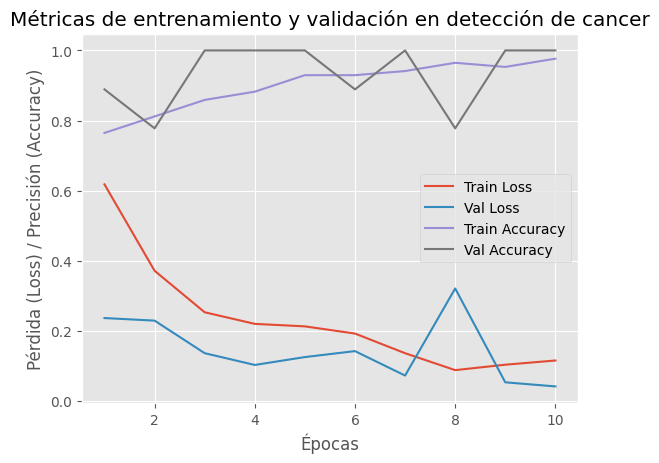

In [ ]:
train_validate_cancer_present(SegGini_model, device, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=10)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_kappa = test_cancer_present(SegGini_model, device, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1-Score: {test_f1:.4f} - Test kappa: {test_kappa:.4f}')

Test Loss: 0.1369 - Test Accuracy: 0.9500
Test Precision: 1.0000 - Test Recall: 0.9375 - Test F1-Score: 0.9677 - Test kappa: 0.8571


**Clasificación de grados ISUP**

In [ ]:
# Definimos el número de características, canales ocultos y número de clases
num_gin_layers = 1
num_features = 2048
hidden_dim = [32,32]
num_classes = 6 # El grado ISUP puede tomar el valor 0,1,2,3,4,5
gin_dropout_rates = [0]
final_dropout_rate = 0
use_batch_norms = [False]
mode = "isup"
use_global_avg_pool = True

# Creamos una instancia del modelo
SegGini_model = SegGiniGraphHead(num_gin_layers, num_features, hidden_dim, num_classes, gin_dropout_rates, final_dropout_rate, use_batch_norms, mode, use_global_avg_pool)
SegGini_model.to(device)

SegGiniGraphHead(
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=2048, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (isup): Linear(in_features=32, out_features=6, bias=True)
)

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SegGini_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.997)

# Llamar a la función de entrenamiento
num_epochs = 10

/content/gdrive/MyDrive/VIU - Máster IA/Asignaturas/TFM/GNN - Prostate Cancer/train_model.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  isup_target = torch.tensor(graph.isup, device=device)
/content/gdrive/MyDrive/VIU - Máster IA/Asignaturas/TFM/GNN - Prostate Cancer/train_model.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  isup_target = torch.tensor(graph.isup, device=device)


Epoch [1/10] - train_loss: 1.9143 - val_loss: 2.0467 - train_acc: 0.2706 - val_acc: 0.2222
Epoch [2/10] - train_loss: 1.7059 - val_loss: 1.5189 - train_acc: 0.3176 - val_acc: 0.5000
Epoch [3/10] - train_loss: 1.3258 - val_loss: 1.1952 - train_acc: 0.5412 - val_acc: 0.6111
Epoch [4/10] - train_loss: 1.2718 - val_loss: 1.0083 - train_acc: 0.5176 - val_acc: 0.7778
Epoch [5/10] - train_loss: 1.1052 - val_loss: 1.0440 - train_acc: 0.5294 - val_acc: 0.7778
Epoch [6/10] - train_loss: 1.0358 - val_loss: 1.0788 - train_acc: 0.5412 - val_acc: 0.8333
Epoch [7/10] - train_loss: 0.8938 - val_loss: 0.9176 - train_acc: 0.6941 - val_acc: 0.8889
Epoch [8/10] - train_loss: 0.8540 - val_loss: 0.8672 - train_acc: 0.6941 - val_acc: 0.8889
Epoch [9/10] - train_loss: 0.8622 - val_loss: 1.5410 - train_acc: 0.7059 - val_acc: 0.6111
Epoch [10/10] - train_loss: 0.8715 - val_loss: 1.1083 - train_acc: 0.6824 - val_acc: 0.8333


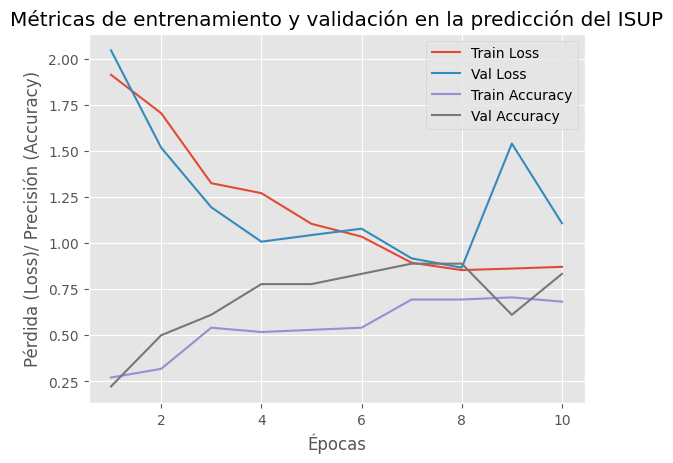

In [ ]:
train_validate_isup(SegGini_model, device, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_kappa = test_isup(SegGini_model, device, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1-Score: {test_f1:.4f} - Test Kappa: {test_kappa:.4f}')

Test Loss: 1.0042 - Test Accuracy: 0.6897
Test Precision: 0.7060 - Test Recall: 0.6897 - Test F1-Score: 0.6631 - Test Kappa: 0.5804


**Clasificación de puntuación Gleason**

La clasificación de la puntuación de Gleason es un proceso multifacético que puede abordarse desde varias perspectivas. Una de las formas es a través de la evaluación de la suma, donde, en lugar de diferenciar entre las etiquetas, consideramos su suma total como una única puntuación; por ejemplo, una combinación de '3+5' se clasificaría directamente con una puntuación de Gleason de 8. Otra forma distingue entre las etiquetas compuestas, donde '3+5' y '5+3' se tratan como categorías separadas debido a la primacía de cada cifra en la suma. Además, se pueden predecir de manera independiente las puntuaciones primaria y secundaria de Gleason. En este contexto, las tareas principales involucradas son:

* **Clasificación de Gleason en base a la suma:** Se suma la puntuación primaria y secundaria y se asigna una única puntuación de Gleason basada en esta suma.
* **Clasificación de Gleason por categorías:** Se mantiene la distinción entre las puntuaciones combinadas, tratando las sumas 'a+b' y 'b+a' como diferentes, donde a,b pueden tomar los valores 0,3,4,5.
* **Clasificación de Gleason primario:** Se enfoca exclusivamente en predecir el grado de Gleason primario.
* **Clasificación de Gleason secundario:** Se enfoca exclusivamente en predecir el grado de Gleason secundario.

* **Clasificación de Gleason en base a la suma**   

In [ ]:
# Definimos el número de características, canales ocultos y número de clases
num_gin_layers = 1
num_features = 2048
hidden_dim = [32,32]
num_classes = 6 # Pueden tomar el valor 0, 6 (3+3), 7 (3+4, 4+3), 8 (4+4), 9 (4+5, 5+4), 10 (5+5)
gin_dropout_rates = [0]
final_dropout_rate = 0
use_batch_norms = [False]
mode = "isup"
use_global_avg_pool = True

# Creamos una instancia del modelo
SegGini_model = SegGiniGraphHead(num_gin_layers, num_features, hidden_dim, num_classes, gin_dropout_rates, final_dropout_rate, use_batch_norms, mode, use_global_avg_pool)
SegGini_model.to(device)

SegGiniGraphHead(
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=2048, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (isup): Linear(in_features=32, out_features=6, bias=True)
)

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SegGini_model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.997)

# Llamar a la función de entrenamiento
num_epochs = 12

Epoch [1/12] - Train Loss: 1.7073 - Train Accuracy: 0.3294 - Val Loss: 1.8348 - Val Accuracy: 0.3333
Epoch [2/12] - Train Loss: 1.5016 - Train Accuracy: 0.4353 - Val Loss: 1.6034 - Val Accuracy: 0.5000
Epoch [3/12] - Train Loss: 1.2769 - Train Accuracy: 0.5412 - Val Loss: 1.3968 - Val Accuracy: 0.5000
Epoch [4/12] - Train Loss: 1.1225 - Train Accuracy: 0.5765 - Val Loss: 1.4472 - Val Accuracy: 0.6667
Epoch [5/12] - Train Loss: 1.0348 - Train Accuracy: 0.6118 - Val Loss: 1.3491 - Val Accuracy: 0.3333
Epoch [6/12] - Train Loss: 0.9695 - Train Accuracy: 0.5765 - Val Loss: 1.3223 - Val Accuracy: 0.7222
Epoch [7/12] - Train Loss: 1.0425 - Train Accuracy: 0.6235 - Val Loss: 1.2971 - Val Accuracy: 0.6111
Epoch [8/12] - Train Loss: 0.9886 - Train Accuracy: 0.5765 - Val Loss: 1.3026 - Val Accuracy: 0.6111
Epoch [9/12] - Train Loss: 0.9552 - Train Accuracy: 0.5765 - Val Loss: 1.3463 - Val Accuracy: 0.6111
Epoch [10/12] - Train Loss: 0.7405 - Train Accuracy: 0.7059 - Val Loss: 1.0487 - Val Accura

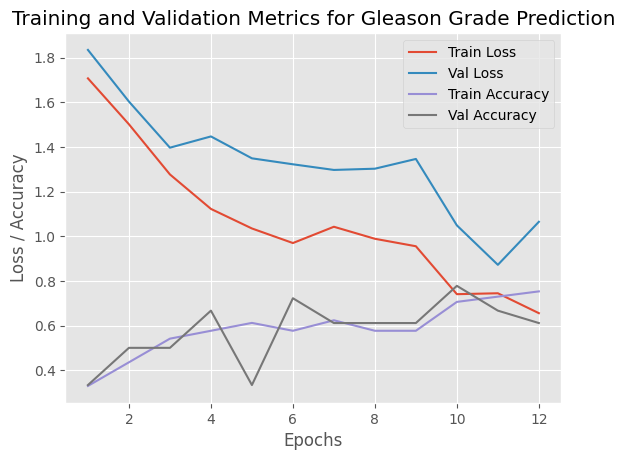

In [ ]:
gleason_mapping = {0: 0, 6: 1, 7: 2, 8: 3, 9: 4, 10: 5}
train_validate_sum_gleason(SegGini_model, device, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, gleason_mapping)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_kappa = test_sum_gleason(SegGini_model, device, test_loader, criterion, gleason_mapping)

print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1-Score: {test_f1:.4f} - Test Kappa: {test_kappa:.4f}')

Test Loss: 0.9616 - Test Accuracy: 0.6842
Test Precision: 0.7595 - Test Recall: 0.6842 - Test F1-Score: 0.6456 - Test Kappa: 0.6017


* **Clasificación de Gleason por categorías**

In [ ]:
# Definimos el número de características, canales ocultos y número de clases
num_gin_layers = 1
num_features = 2048
hidden_dim = [32,32]
num_classes = 4 # Pueden tomar el valor 0, 3, 4, 5
gin_dropout_rates = [0]
final_dropout_rate = 0
use_batch_norms = [False]
mode = "gleason"
use_global_avg_pool = True

# Creamos una instancia del modelo
SegGini_model = SegGiniGraphHead(num_gin_layers, num_features, hidden_dim, num_classes, gin_dropout_rates, final_dropout_rate, use_batch_norms, mode, use_global_avg_pool)
SegGini_model.to(device)

SegGiniGraphHead(
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=2048, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (gleason_primary): Linear(in_features=32, out_features=4, bias=True)
  (gleason_secondary): Linear(in_features=32, out_features=4, bias=True)
)

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SegGini_model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.997)

# Llamar a la función de entrenamiento
num_epochs = 10

Epoch [1/10] - train_loss: 2.7803 - val_loss: 2.8148 - train_combined_acc: 0.1647 - val_combined_acc: 0.2222
Epoch [2/10] - train_loss: 2.5729 - val_loss: 2.1889 - train_combined_acc: 0.2000 - val_combined_acc: 0.2222
Epoch [3/10] - train_loss: 2.2808 - val_loss: 2.1011 - train_combined_acc: 0.2235 - val_combined_acc: 0.5000
Epoch [4/10] - train_loss: 2.0224 - val_loss: 1.9146 - train_combined_acc: 0.4353 - val_combined_acc: 0.4444
Epoch [5/10] - train_loss: 1.8288 - val_loss: 1.8320 - train_combined_acc: 0.3529 - val_combined_acc: 0.4444
Epoch [6/10] - train_loss: 1.6891 - val_loss: 1.7655 - train_combined_acc: 0.5176 - val_combined_acc: 0.3333
Epoch [7/10] - train_loss: 1.6993 - val_loss: 1.7507 - train_combined_acc: 0.4706 - val_combined_acc: 0.5556
Epoch [8/10] - train_loss: 1.4953 - val_loss: 1.4861 - train_combined_acc: 0.5176 - val_combined_acc: 0.5556
Epoch [9/10] - train_loss: 1.4135 - val_loss: 1.7296 - train_combined_acc: 0.5882 - val_combined_acc: 0.6111
Epoch [10/10] - tra

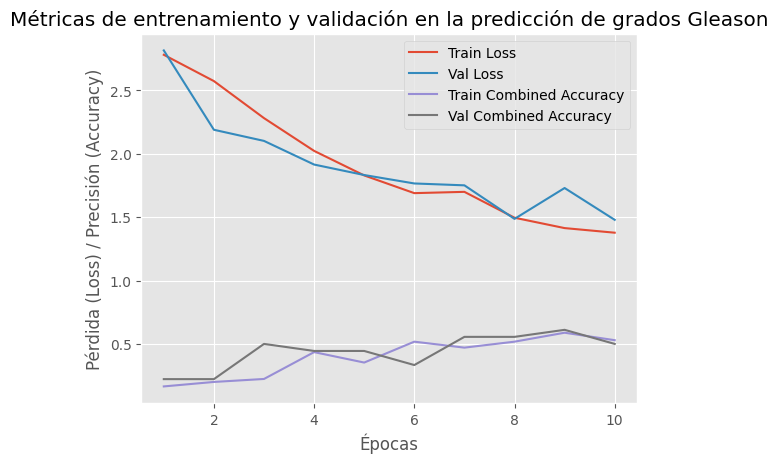

In [ ]:
gleason_mapping = {0: 0, 3: 1, 4: 2, 5: 3}
train_validate_gleason(SegGini_model, device, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, gleason_mapping, train_validate_primary=True, train_validate_secondary=True)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_kappa = test_gleason(SegGini_model, device, test_loader, criterion, gleason_mapping, test_primary=True, test_secondary=True)

print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1-Score: {test_f1:.4f} - Test Kappa: {test_kappa:.4f}')

Test Loss: 1.7599 - Test Accuracy: 0.4828
Test Precision: 0.7220 - Test Recall: 0.4828 - Test F1-Score: 0.4378 - Test Kappa: 0.3983


* **Clasificación de Gleason primario**

In [ ]:
# Definimos el número de características, canales ocultos y número de clases
num_gin_layers = 2
num_features = 2048
hidden_dim = [1024, 512, 128, 32]
num_classes = 4
gin_dropout_rates = [0.7, 0.7]
final_dropout_rate = 0.7
use_batch_norms = [True, True]
mode = "gleason"
use_global_avg_pool = True

# Creamos una instancia del modelo
SegGini_model = SegGiniGraphHead(num_gin_layers, num_features, hidden_dim, num_classes, gin_dropout_rates, final_dropout_rate, use_batch_norms, mode, use_global_avg_pool)
SegGini_model.to(device)

SegGiniGraphHead(
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.7, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.7, inplace=False)
      (4): Linear(in_features=128, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
  )
  (final_dropout): Dropout(p=0.7, inplace=False)
  (gleason_primary): Linear(in_features=32, out_features=4, bias=True)
  (gleas

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SegGini_model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.997)

# Llamar a la función de entrenamiento
num_epochs = 12

Epoch [1/12] - train_loss: 1.3774 - val_loss: 1.2432 - train_primary_acc: 0.2824 - val_primary_acc: 0.4444
Epoch [2/12] - train_loss: 1.1693 - val_loss: 0.9064 - train_primary_acc: 0.4706 - val_primary_acc: 0.5556
Epoch [3/12] - train_loss: 1.1496 - val_loss: 0.8992 - train_primary_acc: 0.4941 - val_primary_acc: 0.6667
Epoch [4/12] - train_loss: 1.1738 - val_loss: 0.8873 - train_primary_acc: 0.5412 - val_primary_acc: 0.7778
Epoch [5/12] - train_loss: 1.0506 - val_loss: 0.8462 - train_primary_acc: 0.5529 - val_primary_acc: 0.7778
Epoch [6/12] - train_loss: 0.9841 - val_loss: 0.9258 - train_primary_acc: 0.6588 - val_primary_acc: 0.8333
Epoch [7/12] - train_loss: 0.9605 - val_loss: 0.9176 - train_primary_acc: 0.7176 - val_primary_acc: 0.7778
Epoch [8/12] - train_loss: 0.8684 - val_loss: 0.8979 - train_primary_acc: 0.7529 - val_primary_acc: 0.7778
Epoch [9/12] - train_loss: 0.8347 - val_loss: 0.6661 - train_primary_acc: 0.7882 - val_primary_acc: 0.8333
Epoch [10/12] - train_loss: 0.7175 - 

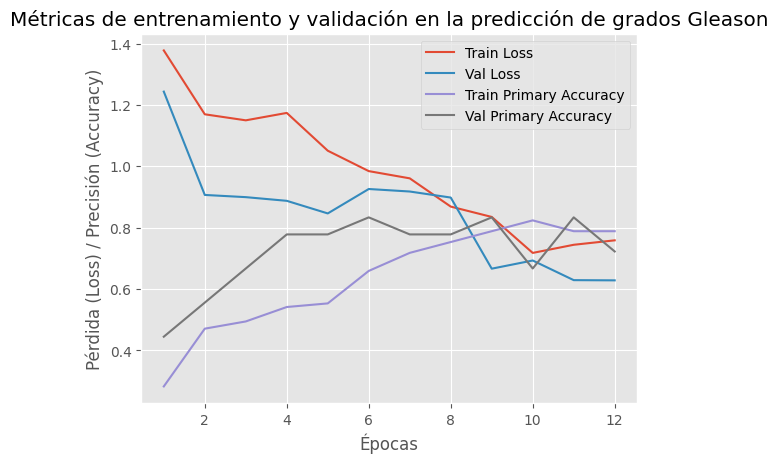

In [ ]:
gleason_mapping = {0: 0, 3: 1, 4: 2, 5: 3}
train_validate_gleason(SegGini_model, device, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, gleason_mapping, train_validate_primary=True, train_validate_secondary=False)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_kappa = test_gleason(SegGini_model, device, test_loader, criterion, gleason_mapping, test_primary=True, test_secondary=False)

print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1-Score: {test_f1:.4f} - Test Kappa: {test_kappa:.4f}')

Test Loss: 0.9577 - Test Accuracy: 0.7368
Test Precision: 0.7701 - Test Recall: 0.7368 - Test F1-Score: 0.7229 - Test Kappa: 0.6192


* **Clasificación de Gleason secundario**

In [ ]:
# Definimos el número de características, canales ocultos y número de clases
num_gin_layers = 1
num_features = 2048
hidden_dim = [512,64]
num_classes = 4
gin_dropout_rates = [0]
final_dropout_rate = 0.6
use_batch_norms = [True]
mode = "gleason"
use_global_avg_pool = True

# Creamos una instancia del modelo
SegGini_model = SegGiniGraphHead(num_gin_layers, num_features, hidden_dim, num_classes, gin_dropout_rates, final_dropout_rate, use_batch_norms, mode, use_global_avg_pool)
SegGini_model.to(device)

SegGiniGraphHead(
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=2048, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
  )
  (final_dropout): Dropout(p=0.6, inplace=False)
  (gleason_primary): Linear(in_features=64, out_features=4, bias=True)
  (gleason_secondary): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SegGini_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.997)

# Llamar a la función de entrenamiento
num_epochs = 12

Epoch [1/12] - train_loss: 1.3623 - val_loss: 1.0021 - train_secondary_acc: 0.3444 - val_secondary_acc: 0.5455
Epoch [2/12] - train_loss: 1.1536 - val_loss: 0.9645 - train_secondary_acc: 0.5111 - val_secondary_acc: 0.5455
Epoch [3/12] - train_loss: 1.1225 - val_loss: 1.0061 - train_secondary_acc: 0.4556 - val_secondary_acc: 0.5455
Epoch [4/12] - train_loss: 1.0891 - val_loss: 0.9953 - train_secondary_acc: 0.5667 - val_secondary_acc: 0.5000
Epoch [5/12] - train_loss: 1.0238 - val_loss: 1.0722 - train_secondary_acc: 0.5556 - val_secondary_acc: 0.4545
Epoch [6/12] - train_loss: 1.0377 - val_loss: 1.0516 - train_secondary_acc: 0.5556 - val_secondary_acc: 0.4091
Epoch [7/12] - train_loss: 0.9773 - val_loss: 1.1760 - train_secondary_acc: 0.6444 - val_secondary_acc: 0.4091
Epoch [8/12] - train_loss: 0.7988 - val_loss: 0.8976 - train_secondary_acc: 0.7222 - val_secondary_acc: 0.6364
Epoch [9/12] - train_loss: 0.8342 - val_loss: 1.0727 - train_secondary_acc: 0.7111 - val_secondary_acc: 0.5455
E

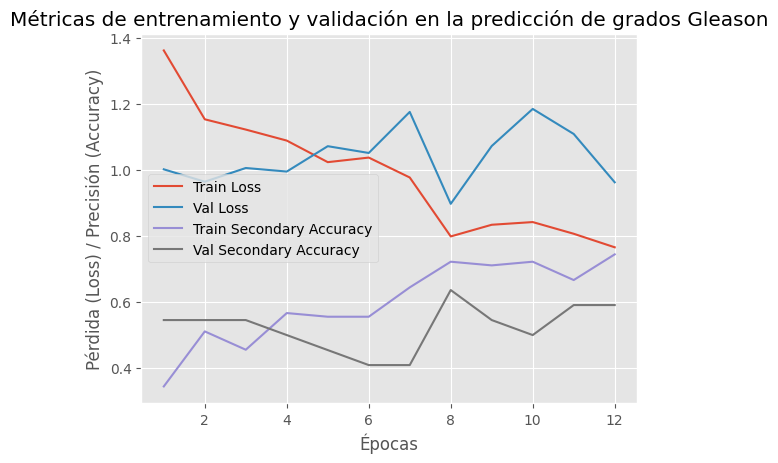

In [ ]:
train_validate_gleason(SegGini_model, device, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, gleason_mapping, train_validate_primary=False, train_validate_secondary=True)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_kappa = test_gleason(SegGini_model, device, test_loader, criterion, gleason_mapping, test_primary=False, test_secondary=True)

print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1-Score: {test_f1:.4f} - Test Kappa: {test_kappa:.4f}')

Test Loss: 1.1258 - Test Accuracy: 0.5517
Test Precision: 0.5414 - Test Recall: 0.5517 - Test F1-Score: 0.5338 - Test Kappa: 0.3850
